In [11]:
import sqlite3
# import os.path
import hashlib
import pandas as pd
import numpy as np

db = './../data/Arne/disaggregation.db'

conn = sqlite3.connect(db)

df = pd.read_sql_query("SELECT date,demand_power_L1+demand_power_L2+demand_power_L3 as 'demand' FROM loads WHERE date BETWEEN datetime('now', '-6 days') AND datetime('now', 'localtime');", conn)

df = pd.read_sql_query("SELECT date,demand_power_L1+demand_power_L2+demand_power_L3 as 'demand' FROM loads WHERE date BETWEEN datetime('now', '-16 days') AND datetime('now', 'localtime');", conn)

conn.close()# close db

df['datetime'] = pd.to_datetime(df['date'])
df.sort_values(by='datetime',ascending=True);


In [12]:
df['dp'] = df['demand'] - df['demand'].shift(1)
df['dp-'] = [0-x if x <=0 else 0 for x in df['dp']]
df['dp+'] = [x if x >=0 else 0 for x in df['dp']]



In [13]:
print(df)

                      date  demand            datetime    dp   dp-   dp+
0      2018-03-21 10:20:21   140.0 2018-03-21 10:20:21   NaN   0.0   0.0
1      2018-03-21 10:20:31   138.0 2018-03-21 10:20:31  -2.0   2.0   0.0
2      2018-03-21 10:20:40   136.0 2018-03-21 10:20:40  -2.0   2.0   0.0
3      2018-03-21 10:20:50   136.0 2018-03-21 10:20:50   0.0   0.0   0.0
4      2018-03-21 10:21:00   134.0 2018-03-21 10:21:00  -2.0   2.0   0.0
5      2018-03-21 10:21:11   129.0 2018-03-21 10:21:11  -5.0   5.0   0.0
6      2018-03-21 10:21:20   139.0 2018-03-21 10:21:20  10.0   0.0  10.0
7      2018-03-21 10:21:30   146.0 2018-03-21 10:21:30   7.0   0.0   7.0
8      2018-03-21 10:21:40   128.0 2018-03-21 10:21:40 -18.0  18.0   0.0
9      2018-03-21 10:21:50   124.0 2018-03-21 10:21:50  -4.0   4.0   0.0
10     2018-03-21 10:22:00   123.0 2018-03-21 10:22:00  -1.0   1.0   0.0
11     2018-03-21 10:22:10   129.0 2018-03-21 10:22:10   6.0   0.0   6.0
12     2018-03-21 10:22:20   124.0 2018-03-21 10:22

In [14]:
# add user defined loads (that are always on)
user_loads = {'modem':10,'rPi':4}
baseload = 0
for user_load in user_loads:
    df.loc[:,user_load]  = user_loads[user_load]
    baseload = baseload + user_loads[user_load]
#     df.loc[:,] = np.array([df['demand'].min()] * len(df))


In [15]:
# find baseload and determine remaining unkwown profile
df.loc[:,'baseload'] = np.array([df['demand'].min()-baseload] * len(df)) #sets baseload colum to min value minus users defined loads
df.loc[:,'unknown'] = df.loc[:,'demand'] - df.loc[:,'baseload']-baseload #calculate remaining load = demand - baseload(s)


# find square loads and save them to a dict

In [16]:
# create a dict to safe found devices/loads
loads = dict()

for x in range(1,len(df)):
    #filter for dP+ with minimim power
    if df.loc[x,'dp+'] > 10:
        print(' ') #new line in output
        print ('start dp>100:',df.loc[x,'datetime'],'start P:',df.loc[x-1,'unknown'],', dP+:' ,df.loc[x,'dp+'])
        
        #look forwar in time to see how long load remains on
        for y in range(x+1,len(df)):
            #find dP- of same/simulair size 
            if df.loc[y,'dp-'] > 0.9 *df.loc[x,'dp+'] and df.loc[y,'dp-'] < 1.1 *df.loc[x,'dp+']:
                print ('stop dP-:',df.loc[y,'datetime'],'dP-:' ,df.loc[y,'dp-'])
                break
            # check if load does not drop below start power (this means is must have been turned of or other loads were already present (=ON))    
            if df.loc[y,'unknown'] <= df.loc[x-1,'unknown']:
                print ('stop demand:',df.loc[x,'datetime'] ,df.loc[y,'unknown'], ' <= ',df.loc[x-1,'unknown'])
                break
            # check for 50% load reduction
            if df.loc[y,'unknown']<df.loc[x-1,'unknown']+0.5*df.loc[x,'dp+']:
                print ('stop 50% load reduction:',df.loc[x,'datetime'] ,df.loc[y,'unknown'], ' < ',df.loc[x-1,'unknown'],'+',0.5*df.loc[x,'dp+'])
                break
            
        
        print(x,y,(df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).mean())
        
        # calculate key parameters
        mean = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).mean()
        max = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).max()
        min = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).min()
        std = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).std()
        time = pd.Timedelta(pd.to_datetime(df['datetime'][y])-pd.to_datetime(df['datetime'][x]))
        noise = df.loc[x+1:y-1,'dp'].abs().mean()
        
        print('mean load:',mean)
        print('max load:',max)
        print('std load:',std)
        print('noise:',noise)
        print('time past:',time)


        print('found profile from ',df.loc[x-1,'datetime'],'to',df.loc[y,'datetime'])
        profile = list(df.loc[x-1:y,'unknown']-df.loc[x-1,'unknown'])
        print(profile)
        
        
#         plt.plot(range(x,y),profile)
#         plt.title('A simple chirp')
#         plt.show()
#         break
        try:
            #drop loads which do not have a square looking profile.
            if (std/mean > 0.15):
                print('dropped because of large std:',std/mean)
                continue

            #drop loads which do not have odd start compared to mean
            if( abs(mean-df.loc[x,'dp+'])/df.loc[x,'dp+'] > 0.2):    
                print('dropped because large difference between mean and start dp+:',abs(mean-df.loc[x,'dp+'])/df.loc[x,'dp+'])
                continue
        except:
            print('Something went wrong in analysing found load, dropping ....')
            continue
#         print('hist:',df.hist(bins=10))
        
        # save this load to the distionairy (group by 'fingerprint')
        fingerprint = str(int(round(mean,-2)))+'_'#+str(int(left_round(df.loc[x,'dp+'],2)))
        temp = {'index':{'start':x,'stop':y},'time':time,'mean':mean,'max':max,'profile':profile}
        try:
            loads[fingerprint][len(loads[fingerprint])] = temp
        except:
            loads[fingerprint] = {0:temp}
            df[fingerprint] = 0 #add new colum to the dataframe before inserting found loads (only on first occurance!)
        
        df.loc[x:y-1,fingerprint] = profile[1:-1]
        df.loc[x:y-1,'unknown'] = df.loc[x:y-1,'unknown'] - profile[1:-1]
        print('Saved with fingerprint:',fingerprint)



 
start dp>100: 2018-03-21 10:26:57 start P: 56.0 , dP+: 22.0
stop demand: 2018-03-21 10:26:57 34.0  <=  56.0
40 42 22.5
mean load: 22.5
max load: 23.0
std load: 0.7071067811865476
noise: 1.0
time past: 0 days 00:00:20
found profile from  2018-03-21 10:26:47 to 2018-03-21 10:27:17
[0.0, 22.0, 23.0, -22.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-21 10:27:27 start P: 34.0 , dP+: 44.0
stop 50% load reduction: 2018-03-21 10:27:27 41.0  <  34.0 + 22.0
43 51 67.375
mean load: 67.375
max load: 205.0
std load: 56.261982850640045
noise: 47.285714285714285
time past: 0 days 00:01:19
found profile from  2018-03-21 10:27:17 to 2018-03-21 10:28:46
[0.0, 44.0, 44.0, 37.0, 45.0, 43.0, 205.0, 58.0, 63.0, 7.0]
dropped because of large std: 0.835057259378702
 
start dp>100: 2018-03-21 10:28:16 start P: 77.0 , dP+: 162.0
stop dP-: 2018-03-21 10:28:26 dP-: 147.0
48 49 162.0
mean load: 162.0
max load: 162.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-21 10:28:

found profile from  2018-03-21 11:05:45 to 2018-03-21 11:06:05
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-21 11:10:13 start P: 32.0 , dP+: 2025.0
stop dP-: 2018-03-21 11:13:11 dP-: 2011.0
302 320 2013.2777777777778
mean load: 2013.2777777777778
max load: 2025.0
std load: 4.54785735659637
noise: 4.823529411764706
time past: 0 days 00:02:58
found profile from  2018-03-21 11:10:03 to 2018-03-21 11:13:11
[0.0, 2025.0, 2011.0, 2017.0, 2012.0, 2010.0, 2012.0, 2011.0, 2020.0, 2016.0, 2008.0, 2015.0, 2018.0, 2012.0, 2006.0, 2011.0, 2011.0, 2013.0, 2011.0, 0.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-21 11:15:30 start P: 32.0 , dP+: 11.0
stop demand: 2018-03-21 11:15:30 32.0  <=  32.0
334 343 45.55555555555556
mean load: 45.55555555555556
max load: 213.0
std load: 64.3022377353835
noise: 52.625
time past: 0 days 00:01:29
found profile from  2018-03-21 11:15:20 to 2018-03-21 11:16:59
[0.0, 11.0, 28.0, 26.0, 23.0, 24.0, 23.0, 

std load: 18.06140320446575
noise: 9.428571428571429
time past: 0 days 00:01:20
found profile from  2018-03-22 01:03:18 to 2018-03-22 01:04:48
[0.0, 2124.0, 2078.0, 2073.0, 2069.0, 2075.0, 2072.0, 2073.0, 2074.0, -1.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-22 03:04:01 start P: 33.0 , dP+: 2055.0
stop dP-: 2018-03-22 03:05:21 dP-: 2038.0
6078 6086 2041.625
mean load: 2041.625
max load: 2055.0
std load: 5.680480361981471
noise: 3.857142857142857
time past: 0 days 00:01:20
found profile from  2018-03-22 03:03:51 to 2018-03-22 03:05:21
[0.0, 2055.0, 2043.0, 2040.0, 2038.0, 2040.0, 2038.0, 2041.0, 2038.0, 0.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-22 03:39:12 start P: 33.0 , dP+: 15.0
stop demand: 2018-03-22 03:39:12 14.0  <=  33.0
6291 6389 39.357142857142854
mean load: 39.357142857142854
max load: 45.0
std load: 6.841730654630851
noise: 0.7216494845360825
time past: 0 days 00:16:10
found profile from  2018-03-22 03:39:02 to 2018-03-22 03:55:22
[0.0, 15.0, 1

stop 50% load reduction: 2018-03-22 16:49:43 31.0  <  29.0 + 5.5
11078 11079 11.0
mean load: 11.0
max load: 11.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-22 16:49:33 to 2018-03-22 16:49:53
[0.0, 11.0, 2.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-22 17:44:12 start P: 33.0 , dP+: 1985.0
stop dP-: 2018-03-22 17:45:32 dP-: 2016.0
11408 11416 1992.75
mean load: 1992.75
max load: 2024.0
std load: 27.436940687432962
noise: 14.428571428571429
time past: 0 days 00:01:20
found profile from  2018-03-22 17:44:02 to 2018-03-22 17:45:32
[0.0, 1985.0, 1969.0, 1963.0, 1957.0, 2013.0, 2010.0, 2021.0, 2024.0, 8.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-22 17:44:52 start P: 33.0 , dP+: 56.0
stop demand: 2018-03-22 17:44:52 33.0  <=  33.0
11412 11413 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-22 17:44:42 to 2018-03-22 17:45:02
[0.0, 0.0, 0.0]
Something went wrong in analys

Saved with fingerprint: 100_
 
start dp>100: 2018-03-23 09:48:15 start P: 1.0 , dP+: 137.0
stop 50% load reduction: 2018-03-23 09:48:15 67.0  <  1.0 + 68.5
17246 17250 101.25
mean load: 101.25
max load: 137.0
std load: 24.12985702402731
noise: 17.666666666666668
time past: 0 days 00:00:39
found profile from  2018-03-23 09:48:05 to 2018-03-23 09:48:54
[0.0, 137.0, 92.0, 92.0, 84.0, 66.0]
dropped because of large std: 0.23831957554594874
 
start dp>100: 2018-03-23 10:23:15 start P: 32.0 , dP+: 16.0
stop demand: 2018-03-23 10:23:15 1.0  <=  32.0
17458 17541 238.13253012048193
mean load: 238.13253012048193
max load: 2028.0
std load: 582.9685547952872
noise: 41.13414634146341
time past: 0 days 00:13:43
found profile from  2018-03-23 10:23:05 to 2018-03-23 10:36:58
[0.0, 16.0, 29.0, 21.0, 17.0, 22.0, 28.0, 30.0, 32.0, 34.0, 35.0, 36.0, 36.0, 37.0, 38.0, 38.0, 39.0, 40.0, 40.0, 40.0, 40.0, 41.0, 41.0, 41.0, 41.0, 41.0, 41.0, 42.0, 42.0, 49.0, 49.0, 49.0, 49.0, 50.0, 43.0, 42.0, 43.0, 43.0, 43

Saved with fingerprint: 2000_
 
start dp>100: 2018-03-23 20:00:04 start P: 34.0 , dP+: 13.0
stop demand: 2018-03-23 20:00:04 3.0  <=  34.0
20951 21031 45.8875
mean load: 45.8875
max load: 57.0
std load: 7.1600045081663195
noise: 1.1012658227848102
time past: 0 days 00:13:13
found profile from  2018-03-23 19:59:54 to 2018-03-23 20:13:17
[0.0, 13.0, 24.0, 21.0, 31.0, 34.0, 36.0, 38.0, 40.0, 41.0, 42.0, 42.0, 43.0, 44.0, 44.0, 45.0, 44.0, 45.0, 46.0, 46.0, 45.0, 46.0, 45.0, 45.0, 45.0, 45.0, 46.0, 46.0, 46.0, 46.0, 47.0, 47.0, 48.0, 48.0, 48.0, 48.0, 48.0, 49.0, 49.0, 49.0, 49.0, 56.0, 57.0, 57.0, 50.0, 50.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 50.0, 51.0, 50.0, 50.0, 50.0, 49.0, 50.0, 49.0, 49.0, 48.0, 48.0, 48.0, 48.0, 47.0, 47.0, 47.0, 45.0, 44.0, 42.0, 39.0, 32.0, -31.0]
dropped because of large std: 0.15603387650593994
 
start dp>100: 2018-03-23 20:00:14 start P: 47.0 , dP+: 11.0
stop demand: 2018-03-23 20:00:14 3.0  <=  47.0
20952 2103

stop dP-: 2018-03-24 05:35:14 dP-: 2053.0
24427 24434 2058.0
mean load: 2058.0
max load: 2066.0
std load: 4.864839839775475
noise: 3.6666666666666665
time past: 0 days 00:01:09
found profile from  2018-03-24 05:33:55 to 2018-03-24 05:35:14
[0.0, 2066.0, 2061.0, 2058.0, 2060.0, 2052.0, 2053.0, 2056.0, 3.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-24 06:46:25 start P: 30.0 , dP+: 12.0
stop 50% load reduction: 2018-03-24 06:46:25 34.0  <  30.0 + 6.0
24865 24867 12.0
mean load: 12.0
max load: 12.0
std load: 0.0
noise: 0.0
time past: 0 days 00:00:19
found profile from  2018-03-24 06:46:15 to 2018-03-24 06:46:44
[0.0, 12.0, 12.0, 4.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-24 06:54:40 start P: 31.0 , dP+: 11.0
stop 50% load reduction: 2018-03-24 06:54:40 33.0  <  31.0 + 5.5
24915 24916 11.0
mean load: 11.0
max load: 11.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 06:54:30 to 2018-03-24 06:54:50
[0.0, 11.0, 2.0]
Saved with finge

26371 26372 771.0
mean load: 771.0
max load: 771.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-24 10:54:57 to 2018-03-24 10:55:16
[0.0, 771.0, 1.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-24 10:58:25 start P: 2.0 , dP+: 757.0
stop dP-: 2018-03-24 10:58:35 dP-: 758.0
26391 26392 757.0
mean load: 757.0
max load: 757.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 10:58:15 to 2018-03-24 10:58:35
[0.0, 757.0, -1.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-24 11:01:43 start P: 2.0 , dP+: 755.0
stop dP-: 2018-03-24 11:01:53 dP-: 756.0
26411 26412 755.0
mean load: 755.0
max load: 755.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 11:01:33 to 2018-03-24 11:01:53
[0.0, 755.0, -1.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-24 11:05:01 start P: 2.0 , dP+: 755.0
stop dP-: 2018-03-24 11:05:11 dP-: 756.0
26431 26432 755.0
mean load: 755.0
max load: 755.0

found profile from  2018-03-24 12:45:05 to 2018-03-24 12:45:25
[0.0, 736.0, 1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 12:49:12 start P: 1.0 , dP+: 730.0
stop dP-: 2018-03-24 12:49:22 dP-: 729.0
27062 27063 730.0
mean load: 730.0
max load: 730.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 12:49:03 to 2018-03-24 12:49:22
[0.0, 730.0, 1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 12:53:10 start P: 2.0 , dP+: 732.0
stop dP-: 2018-03-24 12:53:20 dP-: 733.0
27086 27087 732.0
mean load: 732.0
max load: 732.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 12:53:00 to 2018-03-24 12:53:20
[0.0, 732.0, -1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 12:56:58 start P: 1.0 , dP+: 84.0
stop 50% load reduction: 2018-03-24 12:56:58 2.0  <  1.0 + 42.0
27109 27111 408.5
mean load: 408.5
max load: 733.0
std load: 458.91230099006935
noise: 649.0
time past: 0 days 00:00:20
found profil

start dp>100: 2018-03-24 14:24:40 start P: 2.0 , dP+: 737.0
stop dP-: 2018-03-24 14:24:50 dP-: 738.0
27640 27641 737.0
mean load: 737.0
max load: 737.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 14:24:30 to 2018-03-24 14:24:50
[0.0, 737.0, -1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 14:28:38 start P: 2.0 , dP+: 740.0
stop dP-: 2018-03-24 14:28:48 dP-: 740.0
27664 27665 740.0
mean load: 740.0
max load: 740.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 14:28:28 to 2018-03-24 14:28:48
[0.0, 740.0, 0.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 14:32:35 start P: 2.0 , dP+: 747.0
stop dP-: 2018-03-24 14:32:45 dP-: 748.0
27688 27689 747.0
mean load: 747.0
max load: 747.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 14:32:25 to 2018-03-24 14:32:45
[0.0, 747.0, -1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 14:36:33 start P: 2.0 , d

noise: 2.3333333333333335
time past: 0 days 00:01:10
found profile from  2018-03-25 01:57:35 to 2018-03-25 01:58:54
[0.0, 2070.0, 2064.0, 2064.0, 2061.0, 2062.0, 2064.0, 2062.0, 0.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-25 02:24:10 start P: 34.0 , dP+: 14.0
stop demand: 2018-03-25 02:24:10 3.0  <=  34.0
31997 32109 40.607142857142854
mean load: 40.607142857142854
max load: 47.0
std load: 6.253441780774337
noise: 0.7387387387387387
time past: 0 days 00:18:29
found profile from  2018-03-25 02:24:00 to 2018-03-25 02:42:39
[0.0, 14.0, 16.0, 19.0, 32.0, 35.0, 35.0, 31.0, 30.0, 30.0, 32.0, 33.0, 34.0, 33.0, 33.0, 34.0, 35.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 38.0, 38.0, 38.0, 38.0, 38.0, 39.0, 39.0, 39.0, 39.0, 39.0, 40.0, 40.0, 41.0, 40.0, 40.0, 41.0, 41.0, 41.0, 42.0, 41.0, 42.0, 42.0, 42.0, 41.0, 42.0, 42.0, 41.0, 42.0, 42.0, 43.0, 43.0, 43.0, 42.0, 43.0, 43.0, 43.0, 44.0, 43.0, 43.0, 43.0, 43.0, 44.0, 44.0, 44.0, 44.0, 44.0, 45.0, 45

time past: 0 days 00:01:09
found profile from  2018-03-25 11:51:24 to 2018-03-25 11:52:43
[0.0, 2094.0, 2087.0, 2087.0, 2088.0, 2086.0, 2088.0, 2090.0, 1.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-25 12:00:39 start P: 2.0 , dP+: 64.0
stop 50% load reduction: 2018-03-25 12:00:39 33.0  <  2.0 + 32.0
35488 35504 35.875
mean load: 35.875
max load: 64.0
std load: 8.365604182205452
noise: 2.1333333333333333
time past: 0 days 00:02:38
found profile from  2018-03-25 12:00:29 to 2018-03-25 12:03:17
[0.0, 64.0, 47.0, 37.0, 34.0, 34.0, 34.0, 33.0, 33.0, 33.0, 33.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 31.0]
dropped because of large std: 0.2331875730231485
 
start dp>100: 2018-03-25 13:57:14 start P: 1.0 , dP+: 85.0
stop 50% load reduction: 2018-03-25 13:57:14 43.0  <  1.0 + 42.5
36194 36197 68.0
mean load: 68.0
max load: 85.0
std load: 17.0
noise: 17.0
time past: 0 days 00:00:30
found profile from  2018-03-25 13:57:04 to 2018-03-25 13:57:44
[0.0, 85.0, 68.0, 51.0, 42.0]
dropped becau

stop demand: 2018-03-25 19:30:19 281.0  <=  281.0
38211 38212 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 19:30:09 to 2018-03-25 19:30:29
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-25 19:33:17 start P: 168.0 , dP+: 61.0
stop 50% load reduction: 2018-03-25 19:33:17 197.0  <  168.0 + 30.5
38229 38232 43.666666666666664
mean load: 43.666666666666664
max load: 61.0
std load: 15.14375558880073
noise: 14.0
time past: 0 days 00:00:30
found profile from  2018-03-25 19:33:07 to 2018-03-25 19:33:47
[0.0, 61.0, 37.0, 33.0, 29.0]
dropped because of large std: 0.3468035631023068
 
start dp>100: 2018-03-25 20:26:57 start P: 112.0 , dP+: 84.0
stop demand: 2018-03-25 20:26:57 95.0  <=  112.0
38554 38605 75.84313725490196
mean load: 75.84313725490196
max load: 88.0
std load: 10.13187554013492
noise: 1.4
time past: 0 days 00:08:26
found profile from  2018-03-25 20:26:48 to 201

found profile from  2018-03-25 23:32:23 to 2018-03-25 23:32:53
[0.0, 765.0, 744.0, -1.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-25 23:36:11 start P: 7.0 , dP+: 755.0
stop dP-: 2018-03-25 23:36:21 dP-: 755.0
39700 39701 755.0
mean load: 755.0
max load: 755.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 23:36:01 to 2018-03-25 23:36:21
[0.0, 755.0, 0.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-25 23:39:49 start P: 7.0 , dP+: 751.0
stop dP-: 2018-03-25 23:39:59 dP-: 753.0
39722 39723 751.0
mean load: 751.0
max load: 751.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 23:39:39 to 2018-03-25 23:39:59
[0.0, 751.0, -2.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-25 23:43:27 start P: 5.0 , dP+: 749.0
stop dP-: 2018-03-25 23:43:37 dP-: 749.0
39744 39745 749.0
mean load: 749.0
max load: 749.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 23:43:17 to 

stop dP-: 2018-03-26 01:05:02 dP-: 733.0
40237 40238 734.0
mean load: 734.0
max load: 734.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 01:04:42 to 2018-03-26 01:05:02
[0.0, 734.0, 1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-26 01:08:50 start P: 3.0 , dP+: 110.0
stop 50% load reduction: 2018-03-26 01:08:50 50.0  <  3.0 + 55.0
40261 40268 98.14285714285714
mean load: 98.14285714285714
max load: 112.0
std load: 19.886583177514193
noise: 9.0
time past: 0 days 00:01:09
found profile from  2018-03-26 01:08:40 to 2018-03-26 01:09:59
[0.0, 110.0, 112.0, 112.0, 109.0, 102.0, 82.0, 60.0, 47.0]
dropped because of large std: 0.2026289406733615
 
start dp>100: 2018-03-26 01:45:49 start P: 33.0 , dP+: 30.0
stop demand: 2018-03-26 01:45:49 4.0  <=  33.0
40485 40584 54.86868686868687
mean load: 54.86868686868687
max load: 137.0
std load: 28.405103904931046
noise: 2.826530612244898
time past: 0 days 00:16:21
found profile from  2018-03-26 01:45:39 t

 
start dp>100: 2018-03-26 05:11:54 start P: 33.0 , dP+: 20.0
stop demand: 2018-03-26 05:11:54 33.0  <=  33.0
41733 41734 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 05:11:44 to 2018-03-26 05:12:04
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 05:19:20 start P: 37.0 , dP+: 83.0
stop demand: 2018-03-26 05:19:20 34.0  <=  37.0
41778 41822 84.3409090909091
mean load: 84.3409090909091
max load: 95.0
std load: 8.011454537441802
noise: 1.7906976744186047
time past: 0 days 00:07:16
found profile from  2018-03-26 05:19:10 to 2018-03-26 05:26:36
[0.0, 83.0, 87.0, 89.0, 85.0, 85.0, 84.0, 83.0, 84.0, 85.0, 85.0, 86.0, 89.0, 89.0, 92.0, 88.0, 85.0, 86.0, 86.0, 87.0, 95.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 88.0, 90.0, 88.0, 88.0, 88.0, 88.0, 88.0, 89.0, 89.0, 88.0, 85.0, 74.0, 64.0, 63.0, 64.0, 64.0, 64.0, -3.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03

Saved with fingerprint: 0_
 
start dp>100: 2018-03-26 06:47:11 start P: 192.0 , dP+: 13.0
stop dP-: 2018-03-26 06:57:45 dP-: 13.0
42310 42374 43.453125
mean load: 43.453125
max load: 53.0
std load: 10.451596198439647
noise: 1.4761904761904763
time past: 0 days 00:10:34
found profile from  2018-03-26 06:47:01 to 2018-03-26 06:57:45
[0.0, 13.0, 7.0, 10.0, 10.0, 20.0, 35.0, 34.0, 34.0, 36.0, 38.0, 39.0, 39.0, 40.0, 40.0, 40.0, 41.0, 46.0, 46.0, 46.0, 46.0, 47.0, 48.0, 48.0, 49.0, 50.0, 50.0, 53.0, 53.0, 53.0, 45.0, 43.0, 43.0, 43.0, 43.0, 44.0, 44.0, 45.0, 45.0, 46.0, 46.0, 46.0, 53.0, 53.0, 53.0, 49.0, 49.0, 49.0, 51.0, 51.0, 51.0, 49.0, 46.0, 46.0, 46.0, 47.0, 47.0, 48.0, 50.0, 50.0, 49.0, 49.0, 50.0, 51.0, 50.0, 37.0]
dropped because of large std: 0.24052576652288293
 
start dp>100: 2018-03-26 06:48:01 start P: 212.0 , dP+: 15.0
stop demand: 2018-03-26 06:48:01 204.0  <=  212.0
42315 42407 36.94565217391305
mean load: 36.94565217391305
max load: 102.0
std load: 27.775538344723866
noise

max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 11:32:12 to 2018-03-26 11:32:32
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 12:07:03 start P: 5.0 , dP+: 95.0
stop demand: 2018-03-26 12:07:03 5.0  <=  5.0
44247 44293 85.0
mean load: 85.0
max load: 99.0
std load: 5.719362823873924
noise: 0.6
time past: 0 days 00:07:36
found profile from  2018-03-26 12:06:53 to 2018-03-26 12:14:39
[0.0, 95.0, 98.0, 99.0, 98.0, 98.0, 95.0, 93.0, 91.0, 89.0, 88.0, 87.0, 86.0, 86.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 84.0, 84.0, 84.0, 84.0, 83.0, 83.0, 83.0, 83.0, 82.0, 82.0, 82.0, 82.0, 82.0, 81.0, 81.0, 81.0, 81.0, 80.0, 81.0, 80.0, 80.0, 80.0, 79.0, 79.0, 79.0, 79.0, 78.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 12:42:33 start P: 4.0 , dP+: 100.0
stop demand: 2018-03-26 12:42:33 2.0  <=  4.0
44462 44508 86.08695652173913
mean load: 86.08695652173913
max load: 100.0
std load: 6.

start dp>100: 2018-03-26 13:33:05 start P: 1910.0 , dP+: 64.0
stop demand: 2018-03-26 13:33:05 1910.0  <=  1910.0
44768 44769 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:32:55 to 2018-03-26 13:33:15
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:33:25 start P: 1910.0 , dP+: 13.0
stop demand: 2018-03-26 13:33:25 1910.0  <=  1910.0
44770 44771 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-26 13:33:15 to 2018-03-26 13:33:34
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:33:54 start P: 1910.0 , dP+: 148.0
stop demand: 2018-03-26 13:33:54 1910.0  <=  1910.0
44773 44774 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:33:44 to 2018-03-26 13:34:04
[0.0, 0.0, 0.0]
Somet

found profile from  2018-03-26 13:41:20 to 2018-03-26 13:41:40
[0.0, 0.0, -5.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:42:10 start P: 1719.0 , dP+: 14.0
stop demand: 2018-03-26 13:42:10 1715.0  <=  1719.0
44823 44826 117.33333333333333
mean load: 117.33333333333333
max load: 186.0
std load: 91.08969938106796
noise: 86.0
time past: 0 days 00:00:30
found profile from  2018-03-26 13:42:00 to 2018-03-26 13:42:40
[0.0, 14.0, 152.0, 186.0, -4.0]
dropped because of large std: 0.7763326651795565
 
start dp>100: 2018-03-26 13:42:20 start P: 1733.0 , dP+: 138.0
stop demand: 2018-03-26 13:42:20 1715.0  <=  1733.0
44824 44826 155.0
mean load: 155.0
max load: 172.0
std load: 24.041630560342615
noise: 34.0
time past: 0 days 00:00:20
found profile from  2018-03-26 13:42:10 to 2018-03-26 13:42:40
[0.0, 138.0, 172.0, -18.0]
dropped because of large std: 0.1551072939376943
 
start dp>100: 2018-03-26 13:42:29 start P: 1871.0 , dP+: 34.0
stop demand: 2018

noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-26 13:56:42 to 2018-03-26 13:57:01
[0.0, 31.0, -10.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-26 13:57:11 start P: 386.0 , dP+: 78.0
stop 50% load reduction: 2018-03-26 13:57:11 419.0  <  386.0 + 39.0
44914 44915 78.0
mean load: 78.0
max load: 78.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:57:01 to 2018-03-26 13:57:21
[0.0, 78.0, 33.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 13:57:41 start P: 384.0 , dP+: 1640.0
stop dP-: 2018-03-26 13:58:40 dP-: 1668.0
44917 44923 1656.5
mean load: 1656.5
max load: 1711.0
std load: 64.9083969914525
noise: 81.6
time past: 0 days 00:00:59
found profile from  2018-03-26 13:57:31 to 2018-03-26 13:58:40
[0.0, 1640.0, 1687.0, 1711.0, 1533.0, 1676.0, 1692.0, 24.0]
Saved with fingerprint: 1700_
 
start dp>100: 2018-03-26 13:57:51 start P: 384.0 , dP+: 47.0
stop demand: 2018-03-26 13:57:51 384.0  <=  384.0
44918 44919 0.0
mea

stop demand: 2018-03-26 14:07:16 118.0  <=  136.0
44975 44977 161.0
mean load: 161.0
max load: 162.0
std load: 1.4142135623730951
noise: 2.0
time past: 0 days 00:00:20
found profile from  2018-03-26 14:07:06 to 2018-03-26 14:07:36
[0.0, 160.0, 162.0, -18.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:07:46 start P: 118.0 , dP+: 194.0
stop dP-: 2018-03-26 14:08:05 dP-: 199.0
44978 44980 196.5
mean load: 196.5
max load: 199.0
std load: 3.5355339059327378
noise: 5.0
time past: 0 days 00:00:19
found profile from  2018-03-26 14:07:36 to 2018-03-26 14:08:05
[0.0, 194.0, 199.0, 0.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:08:15 start P: 118.0 , dP+: 182.0
stop dP-: 2018-03-26 14:08:35 dP-: 195.0
44981 44983 188.5
mean load: 188.5
max load: 195.0
std load: 9.192388155425117
noise: 13.0
time past: 0 days 00:00:20
found profile from  2018-03-26 14:08:05 to 2018-03-26 14:08:35
[0.0, 182.0, 195.0, 0.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:08:

 
start dp>100: 2018-03-26 14:16:31 start P: 123.0 , dP+: 196.0
stop dP-: 2018-03-26 14:16:50 dP-: 177.0
45031 45033 187.0
mean load: 187.0
max load: 196.0
std load: 12.727922061357855
noise: 18.0
time past: 0 days 00:00:19
found profile from  2018-03-26 14:16:21 to 2018-03-26 14:16:50
[0.0, 196.0, 178.0, 1.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:17:00 start P: 124.0 , dP+: 185.0
stop demand: 2018-03-26 14:17:00 123.0  <=  124.0
45034 45036 173.5
mean load: 173.5
max load: 185.0
std load: 16.263455967290593
noise: 23.0
time past: 0 days 00:00:20
found profile from  2018-03-26 14:16:50 to 2018-03-26 14:17:20
[0.0, 185.0, 162.0, -1.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:17:30 start P: 123.0 , dP+: 203.0
stop dP-: 2018-03-26 14:17:50 dP-: 195.0
45037 45039 199.0
mean load: 199.0
max load: 203.0
std load: 5.656854249492381
noise: 8.0
time past: 0 days 00:00:20
found profile from  2018-03-26 14:17:20 to 2018-03-26 14:17:50
[0.0, 203.0, 195.0, 0.0

start dp>100: 2018-03-26 14:26:45 start P: 294.0 , dP+: 176.0
stop demand: 2018-03-26 14:26:45 294.0  <=  294.0
45093 45094 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:26:35 to 2018-03-26 14:26:55
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:27:14 start P: 294.0 , dP+: 200.0
stop demand: 2018-03-26 14:27:14 294.0  <=  294.0
45096 45097 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:27:05 to 2018-03-26 14:27:24
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:27:44 start P: 294.0 , dP+: 168.0
stop demand: 2018-03-26 14:27:44 294.0  <=  294.0
45099 45100 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:27:34 to 2018-03-26 14:27:54
[0.0, 0.0, 0.0]
Something we

stop demand: 2018-03-26 14:40:07 33.0  <=  59.0
45174 45178 133.75
mean load: 133.75
max load: 158.0
std load: 25.526130402654715
noise: 30.666666666666668
time past: 0 days 00:00:40
found profile from  2018-03-26 14:39:57 to 2018-03-26 14:40:47
[0.0, 117.0, 158.0, 153.0, 107.0, -26.0]
dropped because of large std: 0.19084957310396047
 
start dp>100: 2018-03-26 14:40:17 start P: 176.0 , dP+: 41.0
stop demand: 2018-03-26 14:40:17 166.0  <=  176.0
45175 45177 38.5
mean load: 38.5
max load: 41.0
std load: 3.5355339059327378
noise: 5.0
time past: 0 days 00:00:20
found profile from  2018-03-26 14:40:07 to 2018-03-26 14:40:37
[0.0, 41.0, 36.0, -10.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-26 14:40:57 start P: 33.0 , dP+: 186.0
stop 50% load reduction: 2018-03-26 14:40:57 97.0  <  33.0 + 93.0
45179 45182 166.33333333333334
mean load: 166.33333333333334
max load: 186.0
std load: 17.897858344878397
noise: 23.0
time past: 0 days 00:00:30
found profile from  2018-03-26 14:40:47 to 201

time past: 0 days 00:00:10
found profile from  2018-03-26 14:51:41 to 2018-03-26 14:52:01
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:52:01 start P: 66.0 , dP+: 24.0
stop dP-: 2018-03-26 16:51:43 dP-: 22.0
45246 45971 309.8124137931035
mean load: 309.8124137931035
max load: 3987.0
std load: 709.8737052955232
noise: 44.66574585635359
time past: 0 days 01:59:42
found profile from  2018-03-26 14:51:51 to 2018-03-26 16:51:43
[0.0, 0.0, 44.0, 1968.0, 2144.0, 2075.0, 2106.0, 1927.0, 1935.0, 2154.0, 2109.0, 2209.0, 2020.0, 2018.0, 2026.0, 2287.0, 2196.0, 225.0, 118.0, 117.0, 423.0, 469.0, 441.0, 153.0, 120.0, 120.0, 448.0, 443.0, 352.0, 97.0, 98.0, 97.0, 404.0, 461.0, 250.0, 29.0, 30.0, 31.0, 372.0, 33.0, 54.0, 54.0, 55.0, 54.0, 53.0, 172.0, 395.0, 116.0, 87.0, 81.0, 688.0, 49.0, 30.0, 118.0, 29.0, 29.0, 29.0, 44.0, 73.0, 130.0, 30.0, 29.0, 29.0, 109.0, 219.0, 234.0, 174.0, 173.0, 243.0, 276.0, 308.0, 418.0, 340.0, 367.0, 373.0, 36

stop 50% load reduction: 2018-03-26 15:01:16 96.0  <  95.0 + 7.5
45302 45305 53.333333333333336
mean load: 53.333333333333336
max load: 101.0
std load: 43.75309512861157
noise: 43.0
time past: 0 days 00:00:29
found profile from  2018-03-26 15:01:05 to 2018-03-26 15:01:45
[0.0, 15.0, 44.0, 101.0, 1.0]
dropped because of large std: 0.8203705336614668
 
start dp>100: 2018-03-26 15:01:26 start P: 110.0 , dP+: 29.0
stop demand: 2018-03-26 15:01:26 96.0  <=  110.0
45303 45305 57.5
mean load: 57.5
max load: 86.0
std load: 40.30508652763321
noise: 57.0
time past: 0 days 00:00:19
found profile from  2018-03-26 15:01:16 to 2018-03-26 15:01:45
[0.0, 29.0, 86.0, -14.0]
dropped because of large std: 0.700958026567534
 
start dp>100: 2018-03-26 15:01:35 start P: 139.0 , dP+: 57.0
stop demand: 2018-03-26 15:01:35 96.0  <=  139.0
45304 45305 57.0
mean load: 57.0
max load: 57.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 15:01:26 to 2018-03-26 15:01:45
[0.0, 57.0,

45379 45406 963.0370370370371
mean load: 963.0370370370371
max load: 2113.0
std load: 1003.4332020035968
noise: 83.61538461538461
time past: 0 days 00:04:28
found profile from  2018-03-26 15:13:48 to 2018-03-26 15:18:26
[0.0, 90.0, 79.0, 81.0, 81.0, 83.0, 82.0, 81.0, 81.0, 82.0, 83.0, 83.0, 82.0, 84.0, 84.0, 83.0, 2113.0, 2094.0, 2102.0, 2104.0, 2096.0, 2095.0, 2027.0, 2026.0, 2025.0, 2029.0, 2024.0, 2028.0, -7.0]
dropped because of large std: 1.0419466369547385
 
start dp>100: 2018-03-26 15:16:27 start P: 201.0 , dP+: 2030.0
stop dP-: 2018-03-26 15:18:26 dP-: 2035.0
45394 45406 1980.5833333333333
mean load: 1980.5833333333333
max load: 2030.0
std load: 39.06046206805159
noise: 11.0
time past: 0 days 00:01:59
found profile from  2018-03-26 15:16:17 to 2018-03-26 15:18:26
[0.0, 2030.0, 2011.0, 2019.0, 2021.0, 2013.0, 2012.0, 1944.0, 1943.0, 1942.0, 1946.0, 1941.0, 1945.0, -90.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-26 15:24:32 start P: 115.0 , dP+: 90.0
stop 50% load re

46000 46066 1738.7424242424242
mean load: 1738.7424242424242
max load: 1954.0
std load: 89.42952715037873
noise: 73.56923076923077
time past: 0 days 00:19:31
found profile from  2018-03-26 16:56:21 to 2018-03-26 17:16:02
[0.0, 1845.0, 1875.0, 1824.0, 1665.0, 1668.0, 1842.0, 1820.0, 1760.0, 1600.0, 1607.0, 1783.0, 1766.0, 1767.0, 1600.0, 1602.0, 1763.0, 1786.0, 1777.0, 1596.0, 1600.0, 1768.0, 1808.0, 1771.0, 1606.0, 1592.0, 1757.0, 1800.0, 1799.0, 1768.0, 1651.0, 1747.0, 1746.0, 1629.0, 1776.0, 1784.0, 1776.0, 1760.0, 1596.0, 1769.0, 1795.0, 1770.0, 1598.0, 1595.0, 1853.0, 1829.0, 1821.0, 1652.0, 1651.0, 1641.0, 1647.0, 1789.0, 1773.0, 1642.0, 1736.0, 1737.0, 1892.0, 1877.0, 1786.0, 1723.0, 1724.0, 1726.0, 1883.0, 1954.0, 1752.0, 1731.0, 1731.0, 214.0]
Saved with fingerprint: 1700_
 
start dp>100: 2018-03-26 16:56:41 start P: 220.0 , dP+: 30.0
stop demand: 2018-03-26 16:56:41 220.0  <=  220.0
46001 46002 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:0

max load: 1883.0
std load: 745.9971179568994
noise: 536.25
time past: 0 days 00:00:50
found profile from  2018-03-26 17:17:11 to 2018-03-26 17:18:11
[0.0, 165.0, 1881.0, 1688.0, 1883.0, 1842.0, 1692.0]
dropped because of large std: 0.500065101191111
 
start dp>100: 2018-03-26 17:17:31 start P: 414.0 , dP+: 1716.0
stop dP-: 2018-03-26 17:20:29 dP-: 1680.0
46075 46093 1643.0555555555557
mean load: 1643.0555555555557
max load: 1718.0
std load: 77.5693027687251
noise: 111.6470588235294
time past: 0 days 00:02:58
found profile from  2018-03-26 17:17:21 to 2018-03-26 17:20:29
[0.0, 1716.0, 1523.0, 1718.0, 1677.0, 1527.0, 1710.0, 1700.0, 1529.0, 1695.0, 1683.0, 1524.0, 1710.0, 1684.0, 1525.0, 1685.0, 1659.0, 1636.0, 1674.0, -6.0]
Saved with fingerprint: 1600_
 
start dp>100: 2018-03-26 17:17:51 start P: 414.0 , dP+: 195.0
stop demand: 2018-03-26 17:17:51 414.0  <=  414.0
46077 46078 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-0

max load: 25.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:27:45 to 2018-03-26 17:28:05
[0.0, 25.0, -140.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-26 17:28:15 start P: 247.0 , dP+: 127.0
stop demand: 2018-03-26 17:28:15 246.0  <=  247.0
46140 46142 154.0
mean load: 154.0
max load: 181.0
std load: 38.18376618407357
noise: 54.0
time past: 0 days 00:00:20
found profile from  2018-03-26 17:28:05 to 2018-03-26 17:28:35
[0.0, 127.0, 181.0, -1.0]
dropped because of large std: 0.24794653366281538
 
start dp>100: 2018-03-26 17:28:25 start P: 374.0 , dP+: 54.0
stop demand: 2018-03-26 17:28:25 246.0  <=  374.0
46141 46142 54.0
mean load: 54.0
max load: 54.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:28:15 to 2018-03-26 17:28:35
[0.0, 54.0, -128.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 17:28:45 start P: 246.0 , dP+: 147.0
stop dP-: 2018-03-26 17:42:08 dP-: 135.0
46143 46224 1965.01234

stop demand: 2018-03-26 17:38:30 420.0  <=  420.0
46202 46203 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:38:20 to 2018-03-26 17:38:40
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:40:19 start P: 420.0 , dP+: 16.0
stop demand: 2018-03-26 17:40:19 420.0  <=  420.0
46213 46214 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:40:09 to 2018-03-26 17:40:29
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:40:39 start P: 420.0 , dP+: 89.0
stop demand: 2018-03-26 17:40:39 420.0  <=  420.0
46215 46216 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:40:29 to 2018-03-26 17:40:49
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 

46278 46296 1697.7222222222222
mean load: 1697.7222222222222
max load: 1996.0
std load: 422.52264896557784
noise: 147.76470588235293
time past: 0 days 00:02:58
found profile from  2018-03-26 17:50:53 to 2018-03-26 17:54:01
[0.0, 109.0, 1989.0, 1996.0, 1994.0, 1983.0, 1978.0, 1965.0, 1660.0, 1653.0, 1662.0, 1665.0, 1652.0, 1708.0, 1731.0, 1654.0, 1660.0, 1745.0, 1755.0, -149.0]
dropped because of large std: 0.24887619625578067
 
start dp>100: 2018-03-26 17:51:13 start P: 2638.0 , dP+: 1880.0
stop dP-: 2018-03-26 17:54:01 dP-: 1904.0
46279 46296 1682.1764705882354
mean load: 1682.1764705882354
max load: 1887.0
std load: 150.50341993378325
noise: 39.5
time past: 0 days 00:02:48
found profile from  2018-03-26 17:51:03 to 2018-03-26 17:54:01
[0.0, 1880.0, 1887.0, 1885.0, 1874.0, 1869.0, 1856.0, 1551.0, 1544.0, 1553.0, 1556.0, 1543.0, 1599.0, 1622.0, 1545.0, 1551.0, 1636.0, 1646.0, -258.0]
Saved with fingerprint: 1700_
 
start dp>100: 2018-03-26 17:53:02 start P: 2638.0 , dP+: 56.0
stop dema

start dp>100: 2018-03-26 18:07:14 start P: 456.0 , dP+: 36.0
stop 50% load reduction: 2018-03-26 18:07:14 457.0  <  456.0 + 18.0
46376 46378 53.0
mean load: 53.0
max load: 70.0
std load: 24.041630560342615
noise: 34.0
time past: 0 days 00:00:20
found profile from  2018-03-26 18:07:04 to 2018-03-26 18:07:34
[0.0, 36.0, 70.0, 1.0]
dropped because of large std: 0.45361567094986066
 
start dp>100: 2018-03-26 18:07:24 start P: 492.0 , dP+: 34.0
stop demand: 2018-03-26 18:07:24 457.0  <=  492.0
46377 46378 34.0
mean load: 34.0
max load: 34.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 18:07:14 to 2018-03-26 18:07:34
[0.0, 34.0, -35.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-26 18:08:43 start P: 165.0 , dP+: 39.0
stop demand: 2018-03-26 18:08:43 145.0  <=  165.0
46385 46493 814.3055555555555
mean load: 814.3055555555555
max load: 2418.0
std load: 988.4873883758928
noise: 93.8411214953271
time past: 0 days 00:17:50
found profile from  2018-03-2

start dp>100: 2018-03-26 19:05:21 start P: 160.0 , dP+: 17.0
stop demand: 2018-03-26 19:05:21 160.0  <=  160.0
46728 46729 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 19:05:11 to 2018-03-26 19:05:31
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 19:06:11 start P: 160.0 , dP+: 13.0
stop demand: 2018-03-26 19:06:11 160.0  <=  160.0
46733 46734 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 19:06:01 to 2018-03-26 19:06:21
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 19:07:00 start P: 160.0 , dP+: 11.0
stop demand: 2018-03-26 19:07:00 160.0  <=  160.0
46738 46739 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 19:06:50 to 2018-03-26 19:07:10
[0.0, 0.0, 0.0]
Something went 

found profile from  2018-03-26 20:32:52 to 2018-03-26 20:33:12
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 20:42:47 start P: 54.0 , dP+: 89.0
stop demand: 2018-03-26 20:42:47 43.0  <=  54.0
47318 47344 73.26923076923077
mean load: 73.26923076923077
max load: 89.0
std load: 9.568940139044418
noise: 2.08
time past: 0 days 00:04:17
found profile from  2018-03-26 20:42:37 to 2018-03-26 20:47:04
[0.0, 89.0, 80.0, 80.0, 80.0, 80.0, 73.0, 74.0, 74.0, 75.0, 75.0, 76.0, 76.0, 77.0, 77.0, 78.0, 79.0, 79.0, 80.0, 81.0, 77.0, 67.0, 57.0, 55.0, 55.0, 56.0, 55.0, -11.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 20:52:51 start P: 43.0 , dP+: 100.0
stop demand: 2018-03-26 20:52:51 42.0  <=  43.0
47379 47405 82.42307692307692
mean load: 82.42307692307692
max load: 100.0
std load: 9.54640488109771
noise: 2.24
time past: 0 days 00:04:18
found profile from  2018-03-26 20:52:41 to 2018-03-26 20:57:09
[0.0, 100.0, 80.0, 84.0, 84.0, 85.

std load: 3.6253078686998625
noise: 2.5
time past: 0 days 00:01:09
found profile from  2018-03-26 22:22:21 to 2018-03-26 22:23:40
[0.0, 90.0, 80.0, 81.0, 80.0, 81.0, 80.0, 81.0, 1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 22:32:35 start P: 9.0 , dP+: 92.0
stop demand: 2018-03-26 22:32:35 9.0  <=  9.0
47983 48014 84.41935483870968
mean load: 84.41935483870968
max load: 92.0
std load: 9.083957263764095
noise: 1.5666666666666667
time past: 0 days 00:05:07
found profile from  2018-03-26 22:32:25 to 2018-03-26 22:37:42
[0.0, 92.0, 81.0, 85.0, 85.0, 85.0, 86.0, 86.0, 86.0, 87.0, 87.0, 88.0, 88.0, 88.0, 89.0, 89.0, 90.0, 91.0, 91.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 89.0, 67.0, 67.0, 67.0, 67.0, 67.0, 67.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 22:42:49 start P: 13.0 , dP+: 89.0
stop demand: 2018-03-26 22:42:49 10.0  <=  13.0
48045 48074 80.24137931034483
mean load: 80.24137931034483
max load: 89.0
std load: 9.057968758477625
noise: 1.4285714285714286

 
start dp>100: 2018-03-27 00:53:16 start P: 90.0 , dP+: 90.0
stop 50% load reduction: 2018-03-27 00:53:16 94.0  <  90.0 + 45.0
48835 48849 82.64285714285714
mean load: 82.64285714285714
max load: 90.0
std load: 2.205138853368957
noise: 1.1538461538461537
time past: 0 days 00:02:19
found profile from  2018-03-27 00:53:07 to 2018-03-27 00:55:35
[0.0, 90.0, 82.0, 81.0, 81.0, 82.0, 82.0, 82.0, 82.0, 83.0, 82.0, 83.0, 82.0, 82.0, 83.0, 4.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 01:03:11 start P: 3.0 , dP+: 95.0
stop demand: 2018-03-27 01:03:11 3.0  <=  3.0
48895 48922 85.07407407407408
mean load: 85.07407407407408
max load: 95.0
std load: 9.097446496876625
noise: 2.0384615384615383
time past: 0 days 00:04:27
found profile from  2018-03-27 01:03:01 to 2018-03-27 01:07:38
[0.0, 95.0, 85.0, 85.0, 86.0, 87.0, 87.0, 86.0, 87.0, 88.0, 89.0, 88.0, 89.0, 89.0, 90.0, 91.0, 92.0, 92.0, 93.0, 93.0, 93.0, 94.0, 80.0, 68.0, 67.0, 68.0, 67.0, 68.0, 0.0]
Saved with fingerprint: 100_
 
s

stop demand: 2018-03-27 03:44:01 3.0  <=  3.0
49869 49897 83.39285714285714
mean load: 83.39285714285714
max load: 92.0
std load: 9.19073319815001
noise: 1.7777777777777777
time past: 0 days 00:04:38
found profile from  2018-03-27 03:43:51 to 2018-03-27 03:48:39
[0.0, 91.0, 81.0, 84.0, 85.0, 85.0, 86.0, 86.0, 86.0, 87.0, 87.0, 87.0, 87.0, 88.0, 88.0, 89.0, 90.0, 91.0, 92.0, 92.0, 92.0, 92.0, 88.0, 67.0, 67.0, 67.0, 66.0, 67.0, 67.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 03:54:06 start P: 3.0 , dP+: 94.0
stop demand: 2018-03-27 03:54:06 3.0  <=  3.0
49930 49957 84.0
mean load: 84.0
max load: 94.0
std load: 9.038379705030525
noise: 1.8076923076923077
time past: 0 days 00:04:27
found profile from  2018-03-27 03:53:56 to 2018-03-27 03:58:33
[0.0, 94.0, 83.0, 84.0, 85.0, 85.0, 85.0, 86.0, 86.0, 87.0, 87.0, 88.0, 88.0, 88.0, 89.0, 90.0, 91.0, 92.0, 92.0, 92.0, 92.0, 92.0, 78.0, 67.0, 67.0, 66.0, 67.0, 67.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 0

max load: 25.0
std load: 2.6574244602443096
noise: 0.65
time past: 0 days 00:03:28
found profile from  2018-03-27 06:24:31 to 2018-03-27 06:28:09
[0.0, 17.0, 18.0, 18.0, 19.0, 18.0, 18.0, 19.0, 19.0, 19.0, 20.0, 20.0, 21.0, 21.0, 22.0, 23.0, 24.0, 24.0, 25.0, 25.0, 25.0, 22.0, 7.0]
dropped because large difference between mean and start dp+: 0.224089635854
 
start dp>100: 2018-03-27 06:34:46 start P: 3.0 , dP+: 75.0
stop 50% load reduction: 2018-03-27 06:34:46 23.0  <  3.0 + 37.5
50903 50927 83.41666666666667
mean load: 83.41666666666667
max load: 93.0
std load: 8.26683613664532
noise: 2.4347826086956523
time past: 0 days 00:03:57
found profile from  2018-03-27 06:34:36 to 2018-03-27 06:38:43
[0.0, 75.0, 83.0, 84.0, 83.0, 84.0, 84.0, 85.0, 85.0, 85.0, 85.0, 87.0, 89.0, 89.0, 89.0, 90.0, 93.0, 87.0, 88.0, 90.0, 89.0, 86.0, 65.0, 64.0, 63.0, 20.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 06:43:01 start P: 0.0 , dP+: 1889.0
stop dP-: 2018-03-27 06:47:09 dP-: 1835.0
50953 50

found profile from  2018-03-27 09:16:56 to 2018-03-27 09:19:44
[0.0, 66.0, 84.0, 85.0, 86.0, 86.0, 87.0, 87.0, 88.0, 88.0, 85.0, 69.0, 68.0, 68.0, 68.0, 67.0, 67.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 09:17:16 start P: 0.0 , dP+: 18.0
stop demand: 2018-03-27 09:17:16 0.0  <=  0.0
51887 51888 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-27 09:17:06 to 2018-03-27 09:17:26
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-27 09:27:10 start P: 5.0 , dP+: 90.0
stop demand: 2018-03-27 09:27:10 1.0  <=  5.0
51947 51998 92.49019607843137
mean load: 92.49019607843137
max load: 192.0
std load: 30.717013233073036
noise: 4.86
time past: 0 days 00:08:26
found profile from  2018-03-27 09:27:01 to 2018-03-27 09:35:36
[0.0, 90.0, 81.0, 81.0, 82.0, 82.0, 82.0, 83.0, 83.0, 177.0, 192.0, 163.0, 162.0, 161.0, 160.0, 158.0, 88.0, 87.0, 85.0, 84.0, 83.0, 84.0, 83.0, 

stop demand: 2018-03-27 11:47:12 1.0  <=  4.0
52795 52813 79.38888888888889
mean load: 79.38888888888889
max load: 92.0
std load: 9.337709058303131
noise: 2.176470588235294
time past: 0 days 00:02:59
found profile from  2018-03-27 11:47:02 to 2018-03-27 11:50:11
[0.0, 92.0, 83.0, 84.0, 84.0, 84.0, 85.0, 85.0, 85.0, 86.0, 86.0, 87.0, 84.0, 77.0, 65.0, 66.0, 66.0, 65.0, 65.0, -3.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 11:56:57 start P: 1.0 , dP+: 87.0
stop demand: 2018-03-27 11:56:57 1.0  <=  1.0
52854 52873 82.10526315789474
mean load: 82.10526315789474
max load: 90.0
std load: 8.562805464735291
noise: 1.9444444444444444
time past: 0 days 00:03:08
found profile from  2018-03-27 11:56:47 to 2018-03-27 12:00:05
[0.0, 87.0, 84.0, 86.0, 87.0, 87.0, 87.0, 87.0, 88.0, 88.0, 88.0, 89.0, 89.0, 90.0, 80.0, 68.0, 68.0, 70.0, 69.0, 68.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 12:07:01 start P: 1.0 , dP+: 92.0
stop demand: 2018-03-27 12:07:01 1.0  <=  1.0
52

stop 50% load reduction: 2018-03-27 14:35:28 7.0  <  1.0 + 7.5
53814 54148 160.4011976047904
mean load: 160.4011976047904
max load: 2054.0
std load: 367.23691218099276
noise: 17.38138138138138
time past: 0 days 00:55:09
found profile from  2018-03-27 14:35:18 to 2018-03-27 15:30:37
[0.0, 15.0, 37.0, 37.0, 37.0, 35.0, 36.0, 42.0, 46.0, 134.0, 126.0, 126.0, 128.0, 127.0, 128.0, 128.0, 129.0, 130.0, 130.0, 130.0, 131.0, 133.0, 132.0, 132.0, 133.0, 141.0, 138.0, 128.0, 117.0, 110.0, 110.0, 109.0, 110.0, 43.0, 43.0, 44.0, 44.0, 45.0, 44.0, 44.0, 43.0, 54.0, 46.0, 44.0, 44.0, 44.0, 46.0, 43.0, 43.0, 44.0, 45.0, 44.0, 43.0, 43.0, 45.0, 44.0, 44.0, 50.0, 45.0, 44.0, 43.0, 45.0, 44.0, 43.0, 43.0, 44.0, 44.0, 43.0, 43.0, 118.0, 129.0, 137.0, 128.0, 128.0, 128.0, 129.0, 130.0, 131.0, 132.0, 132.0, 132.0, 131.0, 132.0, 133.0, 133.0, 134.0, 134.0, 133.0, 110.0, 110.0, 109.0, 109.0, 109.0, 109.0, 43.0, 42.0, 43.0, 42.0, 137.0, 139.0, 141.0, 140.0, 141.0, 139.0, 137.0, 136.0, 133.0, 133.0, 131.0, 133

start dp>100: 2018-03-27 15:52:45 start P: 15.0 , dP+: 234.0
stop 50% load reduction: 2018-03-27 15:52:45 26.0  <  15.0 + 117.0
54282 54699 374.6163069544364
mean load: 374.6163069544364
max load: 2442.0
std load: 482.47304779524126
noise: 22.192307692307693
time past: 0 days 01:08:52
found profile from  2018-03-27 15:52:35 to 2018-03-27 17:01:37
[0.0, 234.0, 209.0, 206.0, 206.0, 205.0, 204.0, 205.0, 204.0, 204.0, 203.0, 203.0, 195.0, 195.0, 194.0, 194.0, 194.0, 193.0, 193.0, 199.0, 200.0, 198.0, 200.0, 199.0, 198.0, 198.0, 201.0, 289.0, 282.0, 276.0, 276.0, 276.0, 277.0, 278.0, 277.0, 278.0, 277.0, 278.0, 279.0, 279.0, 280.0, 281.0, 281.0, 270.0, 258.0, 258.0, 257.0, 257.0, 257.0, 191.0, 190.0, 190.0, 191.0, 191.0, 191.0, 191.0, 191.0, 191.0, 190.0, 190.0, 190.0, 190.0, 190.0, 191.0, 190.0, 191.0, 190.0, 196.0, 191.0, 191.0, 192.0, 192.0, 192.0, 192.0, 191.0, 193.0, 193.0, 193.0, 193.0, 193.0, 193.0, 192.0, 193.0, 193.0, 193.0, 194.0, 194.0, 262.0, 279.0, 278.0, 280.0, 279.0, 279.0, 2

start dp>100: 2018-03-27 16:57:49 start P: 316.0 , dP+: 12.0
stop dP-: 2018-03-27 16:58:08 dP-: 12.0
54676 54678 15.0
mean load: 15.0
max load: 18.0
std load: 4.242640687119285
noise: 6.0
time past: 0 days 00:00:19
found profile from  2018-03-27 16:57:39 to 2018-03-27 16:58:08
[0.0, 12.0, 18.0, 6.0]
dropped because of large std: 0.282842712474619
 
start dp>100: 2018-03-27 17:06:34 start P: 26.0 , dP+: 86.0
stop dP-: 2018-03-27 17:37:46 dP-: 79.0
54729 54918 147.94179894179894
mean load: 147.94179894179894
max load: 311.0
std load: 51.19073427359679
noise: 6.617021276595745
time past: 0 days 00:31:12
found profile from  2018-03-27 17:06:24 to 2018-03-27 17:37:46
[0.0, 86.0, 85.0, 86.0, 87.0, 88.0, 94.0, 94.0, 95.0, 95.0, 97.0, 90.0, 90.0, 90.0, 91.0, 91.0, 92.0, 93.0, 93.0, 94.0, 94.0, 93.0, 79.0, 68.0, 67.0, 68.0, 68.0, 67.0, 126.0, 125.0, 125.0, 125.0, 149.0, 129.0, 153.0, 165.0, 154.0, 151.0, 143.0, 140.0, 141.0, 140.0, 141.0, 140.0, 144.0, 144.0, 144.0, 145.0, 146.0, 145.0, 145.0, 

found profile from  2018-03-27 18:45:09 to 2018-03-27 19:01:30
[0.0, 20.0, 20.0, 21.0, 21.0, 21.0, 21.0, 28.0, 28.0, 28.0, 28.0, 32.0, 32.0, 32.0, 29.0, 125.0, 117.0, 110.0, 110.0, 110.0, 110.0, 111.0, 111.0, 112.0, 112.0, 112.0, 113.0, 113.0, 114.0, 114.0, 115.0, 116.0, 104.0, 92.0, 91.0, 91.0, 92.0, 92.0, 119.0, 122.0, 130.0, 129.0, 124.0, 113.0, 95.0, 73.0, 77.0, 75.0, 75.0, 75.0, 88.0, 78.0, 76.0, 73.0, 73.0, 76.0, 75.0, 75.0, 74.0, 72.0, 70.0, 72.0, 68.0, 73.0, 70.0, 72.0, 71.0, 70.0, 71.0, 71.0, 69.0, 73.0, 70.0, 68.0, 70.0, 73.0, 163.0, 156.0, 154.0, 156.0, 153.0, 74.0, 75.0, 77.0, 78.0, 79.0, 76.0, 78.0, 74.0, 73.0, 74.0, 80.0, 78.0, 68.0, 51.0, 55.0, 51.0, 69.0, 55.0, -14.0]
dropped because of large std: 0.4081072293284939
 
start dp>100: 2018-03-27 18:47:38 start P: 107.0 , dP+: 96.0
stop 50% load reduction: 2018-03-27 18:47:38 151.0  <  107.0 + 48.0
55341 55371 81.63333333333334
mean load: 81.63333333333334
max load: 101.0
std load: 11.037501383085267
noise: 4.13793103448275

stop demand: 2018-03-27 20:08:52 66.0  <=  66.0
55833 55834 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-27 20:08:42 to 2018-03-27 20:09:02
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-27 20:12:50 start P: 80.0 , dP+: 94.0
stop 50% load reduction: 2018-03-27 20:12:50 90.0  <  80.0 + 47.0
55857 55911 736.7592592592592
mean load: 736.7592592592592
max load: 2060.0
std load: 892.8935776173912
noise: 76.94339622641509
time past: 0 days 00:08:55
found profile from  2018-03-27 20:12:40 to 2018-03-27 20:21:45
[0.0, 94.0, 96.0, 98.0, 97.0, 97.0, 96.0, 94.0, 92.0, 91.0, 89.0, 88.0, 88.0, 88.0, 97.0, 98.0, 2011.0, 1984.0, 1980.0, 1980.0, 1980.0, 1978.0, 1976.0, 1975.0, 1974.0, 1973.0, 1973.0, 1970.0, 1973.0, 1973.0, 1972.0, 1974.0, 2057.0, 2060.0, 177.0, 177.0, 184.0, 185.0, 177.0, 178.0, 178.0, 178.0, 105.0, 107.0, 107.0, 100.0, 102.0, 102.0, 94.0, 78.0, 78.0, 78.0, 78.0, 7

found profile from  2018-03-27 22:16:30 to 2018-03-27 22:23:26
[0.0, 95.0, 97.0, 99.0, 105.0, 103.0, 102.0, 100.0, 98.0, 96.0, 95.0, 90.0, 161.0, 176.0, 181.0, 180.0, 175.0, 180.0, 175.0, 176.0, 176.0, 175.0, 175.0, 176.0, 175.0, 177.0, 177.0, 173.0, 155.0, 152.0, 153.0, 151.0, 151.0, 151.0, 82.0, 82.0, 81.0, 82.0, 82.0, 81.0, 80.0, 81.0, 1.0]
dropped because of large std: 0.30605586622919917
 
start dp>100: 2018-03-27 22:18:29 start P: 93.0 , dP+: 71.0
stop dP-: 2018-03-27 22:22:07 dP-: 69.0
56618 56640 79.13636363636364
mean load: 79.13636363636364
max load: 91.0
std load: 11.302319418704474
noise: 3.3333333333333335
time past: 0 days 00:03:38
found profile from  2018-03-27 22:18:19 to 2018-03-27 22:22:07
[0.0, 71.0, 86.0, 91.0, 90.0, 85.0, 90.0, 85.0, 86.0, 86.0, 85.0, 85.0, 86.0, 85.0, 87.0, 87.0, 83.0, 65.0, 62.0, 63.0, 61.0, 61.0, 61.0, -8.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 22:18:39 start P: 93.0 , dP+: 15.0
stop demand: 2018-03-27 22:18:39 93.0  <=  93.0


max load: 94.0
std load: 8.816979666233932
noise: 1.9130434782608696
time past: 0 days 00:03:58
found profile from  2018-03-27 23:58:23 to 2018-03-28 00:02:31
[0.0, 90.0, 84.0, 87.0, 88.0, 88.0, 88.0, 89.0, 89.0, 90.0, 92.0, 92.0, 92.0, 91.0, 92.0, 92.0, 92.0, 93.0, 94.0, 81.0, 71.0, 69.0, 69.0, 69.0, 70.0, -1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 00:08:38 start P: 7.0 , dP+: 85.0
stop demand: 2018-03-28 00:08:38 3.0  <=  7.0
57285 57309 82.04166666666667
mean load: 82.04166666666667
max load: 90.0
std load: 9.086440766169197
noise: 1.3478260869565217
time past: 0 days 00:03:57
found profile from  2018-03-28 00:08:28 to 2018-03-28 00:12:35
[0.0, 85.0, 84.0, 85.0, 85.0, 86.0, 86.0, 86.0, 86.0, 87.0, 87.0, 88.0, 88.0, 88.0, 89.0, 90.0, 90.0, 90.0, 87.0, 72.0, 66.0, 66.0, 66.0, 66.0, 66.0, -4.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 00:18:32 start P: 4.0 , dP+: 95.0
stop demand: 2018-03-28 00:18:32 4.0  <=  4.0
57345 57369 85.29166666666667
mean load

stop demand: 2018-03-28 02:49:08 4.0  <=  4.0
58257 58281 85.41666666666667
mean load: 85.41666666666667
max load: 94.0
std load: 8.796820901383322
noise: 1.7391304347826086
time past: 0 days 00:03:58
found profile from  2018-03-28 02:48:58 to 2018-03-28 02:53:06
[0.0, 89.0, 85.0, 89.0, 88.0, 89.0, 89.0, 89.0, 89.0, 89.0, 90.0, 90.0, 91.0, 91.0, 92.0, 93.0, 93.0, 94.0, 92.0, 81.0, 70.0, 70.0, 69.0, 69.0, 69.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 02:59:13 start P: 3.0 , dP+: 90.0
stop 50% load reduction: 2018-03-28 02:59:13 4.0  <  3.0 + 45.0
58318 58342 85.91666666666667
mean load: 85.91666666666667
max load: 95.0
std load: 9.282600210429546
noise: 1.565217391304348
time past: 0 days 00:03:57
found profile from  2018-03-28 02:59:03 to 2018-03-28 03:03:10
[0.0, 90.0, 87.0, 89.0, 89.0, 89.0, 89.0, 90.0, 91.0, 91.0, 91.0, 91.0, 92.0, 93.0, 93.0, 93.0, 94.0, 95.0, 92.0, 73.0, 70.0, 70.0, 70.0, 70.0, 70.0, 1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28

start dp>100: 2018-03-28 06:08:17 start P: 1.0 , dP+: 95.0
stop dP-: 2018-03-28 06:30:14 dP-: 103.0
59463 59596 477.7894736842105
mean load: 477.7894736842105
max load: 2277.0
std load: 734.6743254216877
noise: 85.27272727272727
time past: 0 days 00:21:57
found profile from  2018-03-28 06:08:07 to 2018-03-28 06:30:14
[0.0, 95.0, 98.0, 100.0, 100.0, 99.0, 100.0, 96.0, 2168.0, 2130.0, 2122.0, 2122.0, 2114.0, 2096.0, 2108.0, 2232.0, 2228.0, 2232.0, 2231.0, 2230.0, 2249.0, 2277.0, 2266.0, 2257.0, 2259.0, 2255.0, 233.0, 234.0, 232.0, 230.0, 229.0, 229.0, 229.0, 228.0, 221.0, 227.0, 228.0, 227.0, 227.0, 233.0, 221.0, 219.0, 218.0, 225.0, 146.0, 148.0, 148.0, 147.0, 146.0, 146.0, 146.0, 146.0, 146.0, 145.0, 146.0, 146.0, 146.0, 145.0, 146.0, 146.0, 139.0, 146.0, 147.0, 147.0, 146.0, 139.0, 139.0, 138.0, 138.0, 138.0, 122.0, 122.0, 122.0, 122.0, 122.0, 123.0, 122.0, 122.0, 121.0, 122.0, 126.0, 208.0, 203.0, 212.0, 213.0, 214.0, 214.0, 214.0, 211.0, 210.0, 189.0, 189.0, 195.0, 196.0, 189.0, 123

[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:30:54 start P: 140.0 , dP+: 149.0
stop demand: 2018-03-28 06:30:54 140.0  <=  140.0
59600 59601 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:30:44 to 2018-03-28 06:31:04
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:31:04 start P: 140.0 , dP+: 23.0
stop demand: 2018-03-28 06:31:04 140.0  <=  140.0
59601 59602 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:30:54 to 2018-03-28 06:31:14
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:31:14 start P: 140.0 , dP+: 15.0
stop demand: 2018-03-28 06:31:14 140.0  <=  140.0
59602 59603 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile f

start dp>100: 2018-03-28 06:53:41 start P: 140.0 , dP+: 28.0
stop demand: 2018-03-28 06:53:41 140.0  <=  140.0
59738 59739 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:53:31 to 2018-03-28 06:53:51
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:54:40 start P: 140.0 , dP+: 24.0
stop dP-: 2018-03-28 06:54:50 dP-: 24.0
59744 59745 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:54:30 to 2018-03-28 06:54:50
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:55:10 start P: 140.0 , dP+: 136.0
stop demand: 2018-03-28 06:55:10 140.0  <=  140.0
59747 59748 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:55:00 to 2018-03-28 06:55:20
[0.0, 0.0, 0.0]
Something went wrong in 

noise: 26.571428571428573
time past: 0 days 00:01:19
found profile from  2018-03-28 07:06:14 to 2018-03-28 07:07:43
[0.0, 29.0, 37.0, 162.0, 122.0, 120.0, 113.0, 111.0, 109.0, -7.0]
dropped because of large std: 0.4472560492521293
 
start dp>100: 2018-03-28 07:06:44 start P: 70.0 , dP+: 125.0
stop dP-: 2018-03-28 07:07:43 dP-: 116.0
59817 59823 85.83333333333333
mean load: 85.83333333333333
max load: 125.0
std load: 19.853631070075483
noise: 10.6
time past: 0 days 00:00:59
found profile from  2018-03-28 07:06:34 to 2018-03-28 07:07:43
[0.0, 125.0, 85.0, 83.0, 76.0, 74.0, 72.0, -44.0]
dropped because of large std: 0.23130443965136488
 
start dp>100: 2018-03-28 07:08:33 start P: 12.0 , dP+: 13.0
stop 50% load reduction: 2018-03-28 07:08:33 18.0  <  12.0 + 6.5
59828 59833 54.2
mean load: 54.2
max load: 91.0
std load: 38.36274234201721
noise: 39.0
time past: 0 days 00:00:49
found profile from  2018-03-28 07:08:23 to 2018-03-28 07:09:22
[0.0, 13.0, 70.0, 84.0, 91.0, 13.0, 6.0]
dropped becau

59913 59915 193.0
mean load: 193.0
max load: 198.0
std load: 7.0710678118654755
noise: 10.0
time past: 0 days 00:00:20
found profile from  2018-03-28 07:22:25 to 2018-03-28 07:22:55
[0.0, 198.0, 188.0, 93.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-28 07:23:34 start P: 102.0 , dP+: 248.0
stop 50% load reduction: 2018-03-28 07:23:34 120.0  <  102.0 + 124.0
59919 59921 219.0
mean load: 219.0
max load: 248.0
std load: 41.012193308819754
noise: 58.0
time past: 0 days 00:00:20
found profile from  2018-03-28 07:23:24 to 2018-03-28 07:23:54
[0.0, 248.0, 190.0, 18.0]
dropped because of large std: 0.18727028908136875
 
start dp>100: 2018-03-28 07:24:34 start P: 87.0 , dP+: 209.0
stop demand: 2018-03-28 07:24:34 86.0  <=  87.0
59925 59927 167.5
mean load: 167.5
max load: 209.0
std load: 58.68986283848344
noise: 83.0
time past: 0 days 00:00:20
found profile from  2018-03-28 07:24:24 to 2018-03-28 07:24:54
[0.0, 209.0, 126.0, -1.0]
dropped because of large std: 0.3503872408267668
 
sta

start dp>100: 2018-03-28 08:51:25 start P: 99.0 , dP+: 92.0
stop demand: 2018-03-28 08:51:25 99.0  <=  99.0
60451 60452 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 08:51:15 to 2018-03-28 08:51:35
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 08:51:35 start P: 99.0 , dP+: 66.0
stop demand: 2018-03-28 08:51:35 99.0  <=  99.0
60452 60453 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 08:51:25 to 2018-03-28 08:51:45
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 08:52:24 start P: 122.0 , dP+: 51.0
stop demand: 2018-03-28 08:52:24 13.0  <=  122.0
60457 60459 43.5
mean load: 43.5
max load: 51.0
std load: 10.606601717798213
noise: 15.0
time past: 0 days 00:00:20
found profile from  2018-03-28 08:52:14 to 2018-03-28 08:52:44
[0.0, 51.0, 36.0, -

[0.0, 147.0, 225.0, 207.0, 0.0]
dropped because of large std: 0.21161220576851958
 
start dp>100: 2018-03-28 09:04:38 start P: 152.0 , dP+: 78.0
stop demand: 2018-03-28 09:04:38 5.0  <=  152.0
60531 60533 69.0
mean load: 69.0
max load: 78.0
std load: 12.727922061357855
noise: 18.0
time past: 0 days 00:00:19
found profile from  2018-03-28 09:04:28 to 2018-03-28 09:04:57
[0.0, 78.0, 60.0, -147.0]
dropped because of large std: 0.1844626385704037
 
start dp>100: 2018-03-28 09:05:07 start P: 5.0 , dP+: 14.0
stop demand: 2018-03-28 09:05:07 5.0  <=  5.0
60534 60544 147.6
mean load: 147.6
max load: 320.0
std load: 123.95088633092634
noise: 119.0
time past: 0 days 00:01:39
found profile from  2018-03-28 09:04:57 to 2018-03-28 09:06:46
[0.0, 14.0, 206.0, 159.0, 284.0, 14.0, 13.0, 14.0, 261.0, 320.0, 191.0, 0.0]
dropped because of large std: 0.8397756526485525
 
start dp>100: 2018-03-28 09:05:17 start P: 19.0 , dP+: 192.0
stop demand: 2018-03-28 09:05:17 19.0  <=  19.0
60535 60538 202.3333333333

time past: 0 days 00:00:10
found profile from  2018-03-28 09:15:21 to 2018-03-28 09:15:41
[0.0, 43.0, -8.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-28 09:16:51 start P: 20.0 , dP+: 40.0
stop dP-: 2018-03-28 09:17:40 dP-: 40.0
60605 60610 226.0
mean load: 226.0
max load: 399.0
std load: 138.71012940661544
noise: 166.75
time past: 0 days 00:00:49
found profile from  2018-03-28 09:16:41 to 2018-03-28 09:17:40
[0.0, 40.0, 298.0, 144.0, 249.0, 399.0, 359.0]
dropped because of large std: 0.6137616345425462
 
start dp>100: 2018-03-28 09:17:01 start P: 60.0 , dP+: 258.0
stop 50% load reduction: 2018-03-28 09:17:01 164.0  <  60.0 + 129.0
60606 60607 258.0
mean load: 258.0
max load: 258.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-28 09:16:51 to 2018-03-28 09:17:10
[0.0, 258.0, 104.0]
Saved with fingerprint: 300_
 
start dp>100: 2018-03-28 09:17:20 start P: 164.0 , dP+: 105.0
stop demand: 2018-03-28 09:17:20 20.0  <=  164.0
60608 60621 193.0
mean l

0_ has 113 occurance(s)
1000_ has 2 occurance(s)
100_ has 280 occurance(s)
1100_ has 1 occurance(s)
1200_ has 3 occurance(s)
1300_ has 5 occurance(s)
1400_ has 1 occurance(s)
1500_ has 4 occurance(s)
1600_ has 3 occurance(s)
1700_ has 8 occurance(s)
1800_ has 2 occurance(s)
1900_ has 12 occurance(s)
2000_ has 57 occurance(s)
200_ has 77 occurance(s)
2100_ has 39 occurance(s)
2300_ has 1 occurance(s)
300_ has 18 occurance(s)
400_ has 3 occurance(s)
500_ has 5 occurance(s)
600_ has 4 occurance(s)


/Applications/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


700_ has 66 occurance(s)
800_ has 43 occurance(s)
900_ has 1 occurance(s)


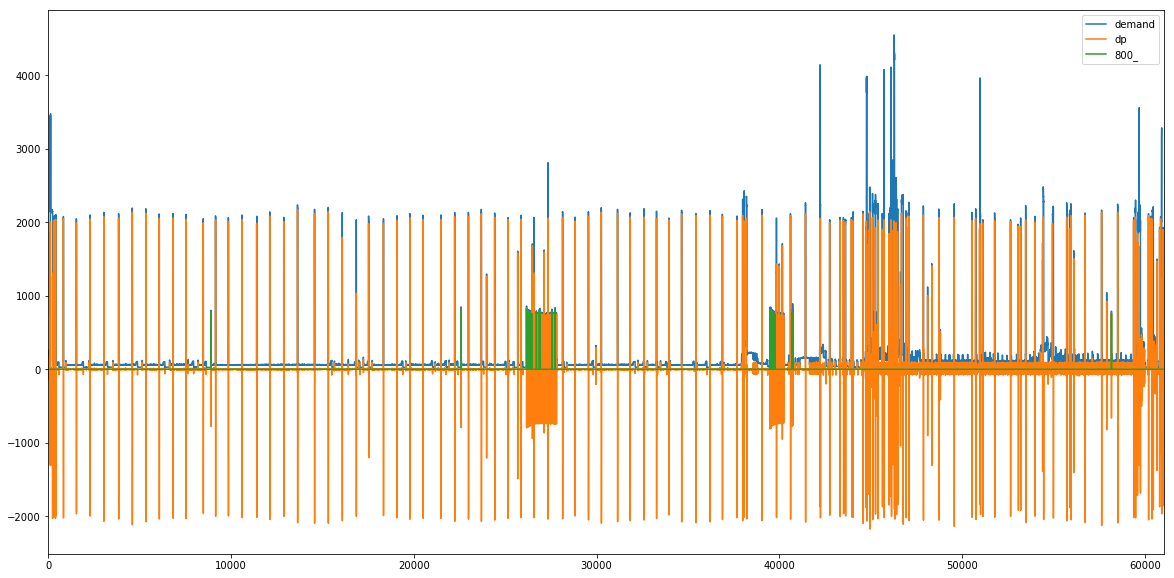

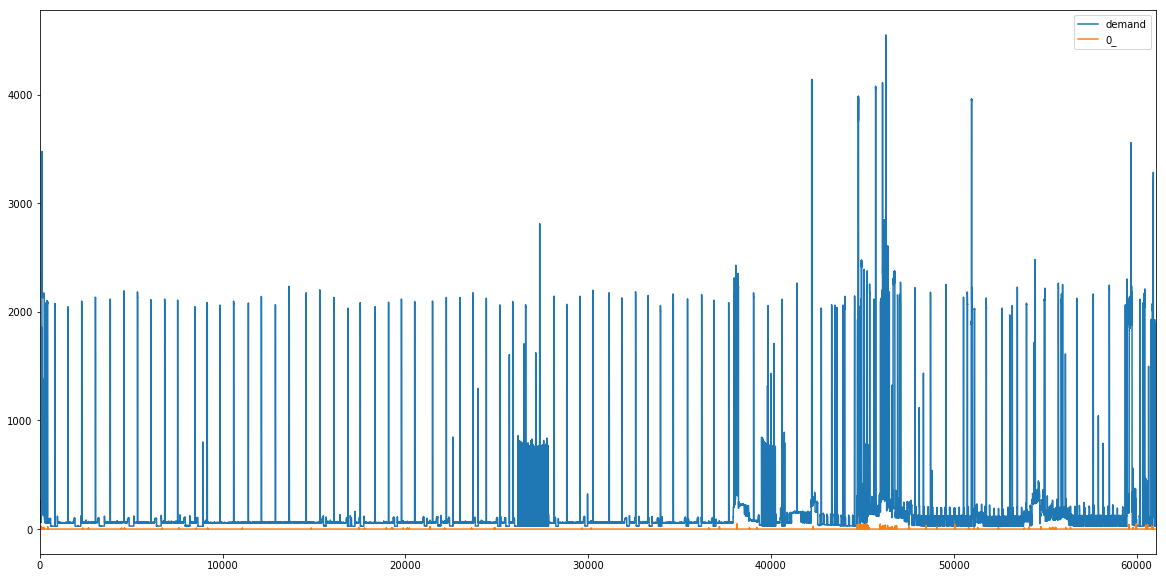

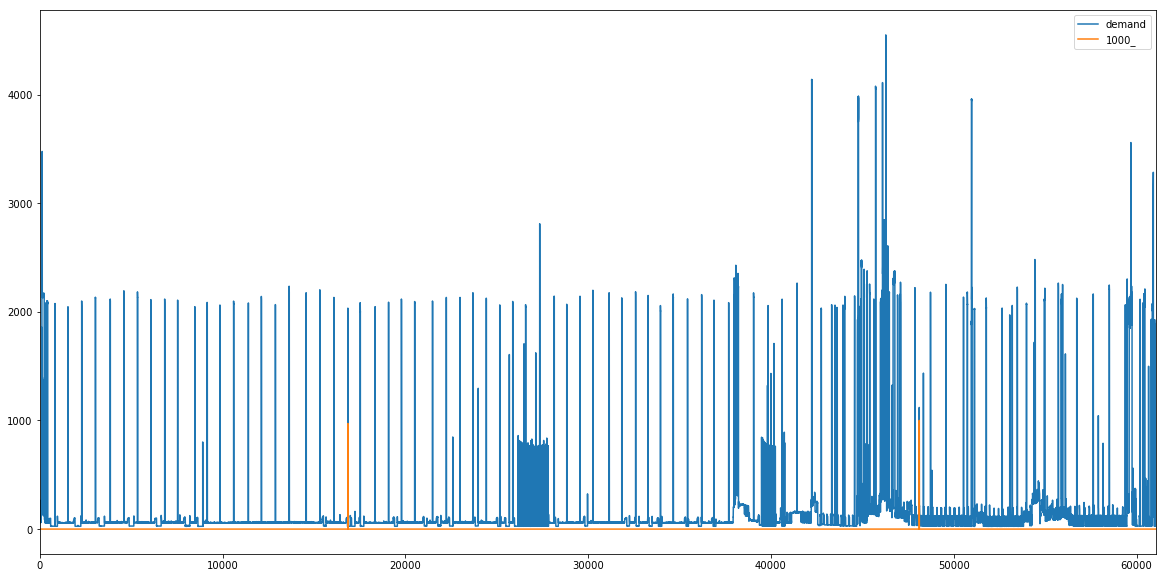

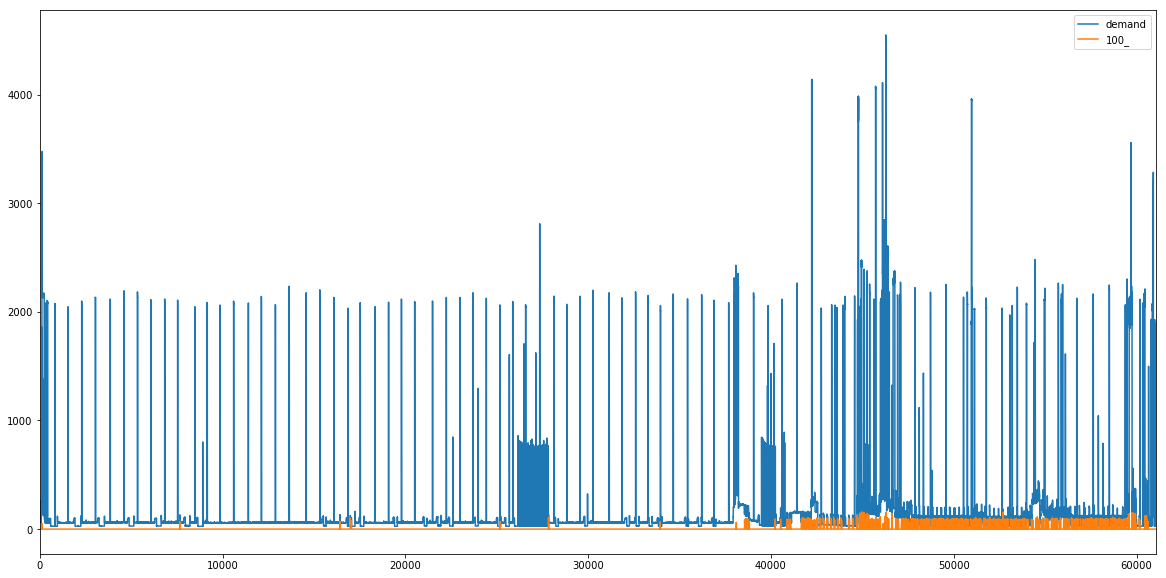

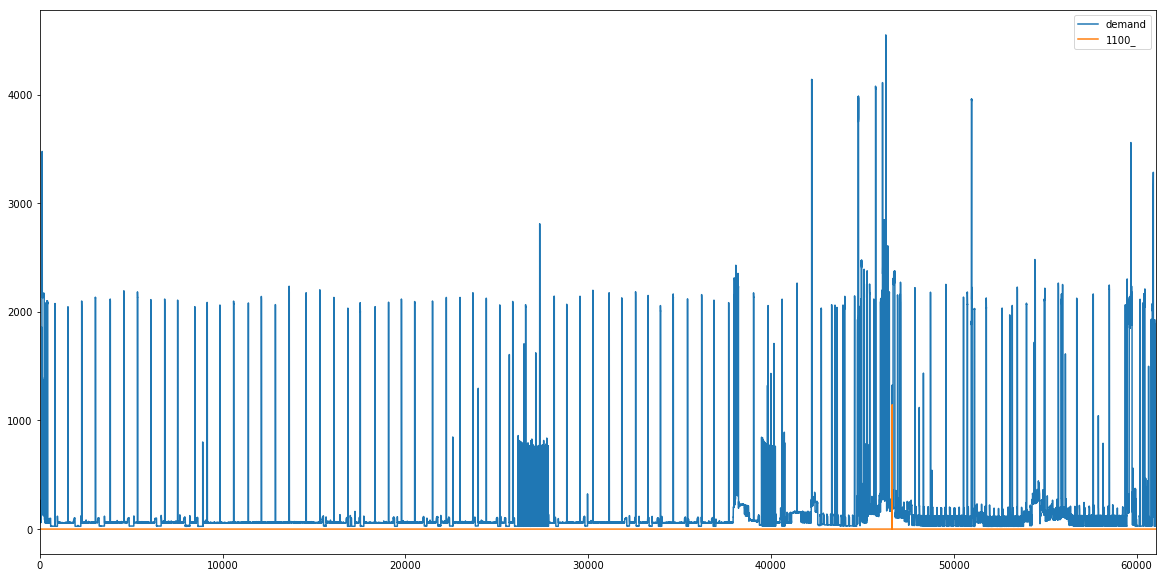

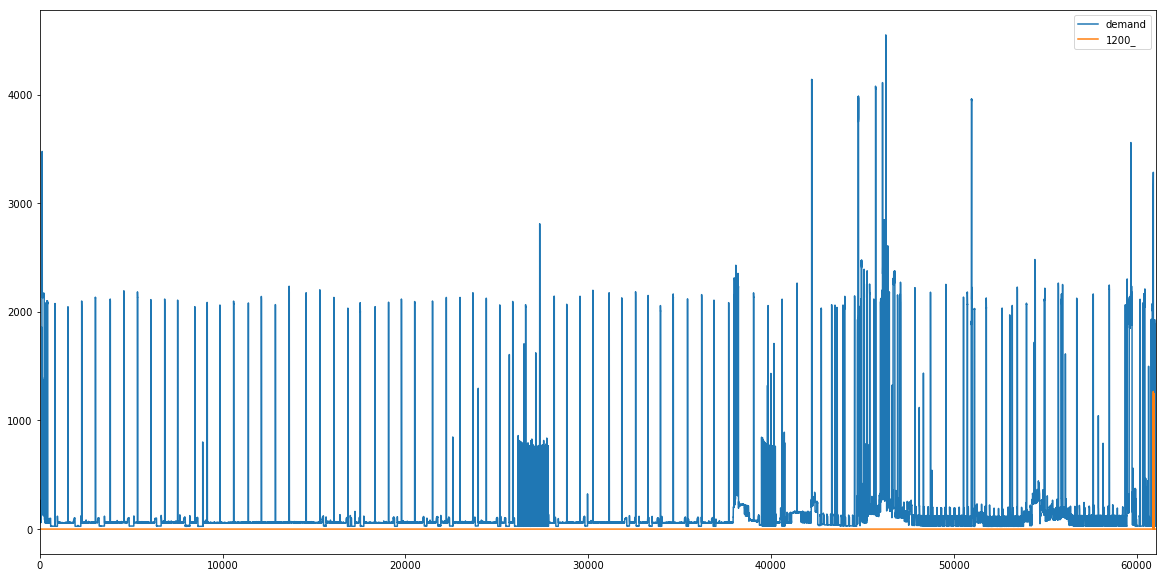

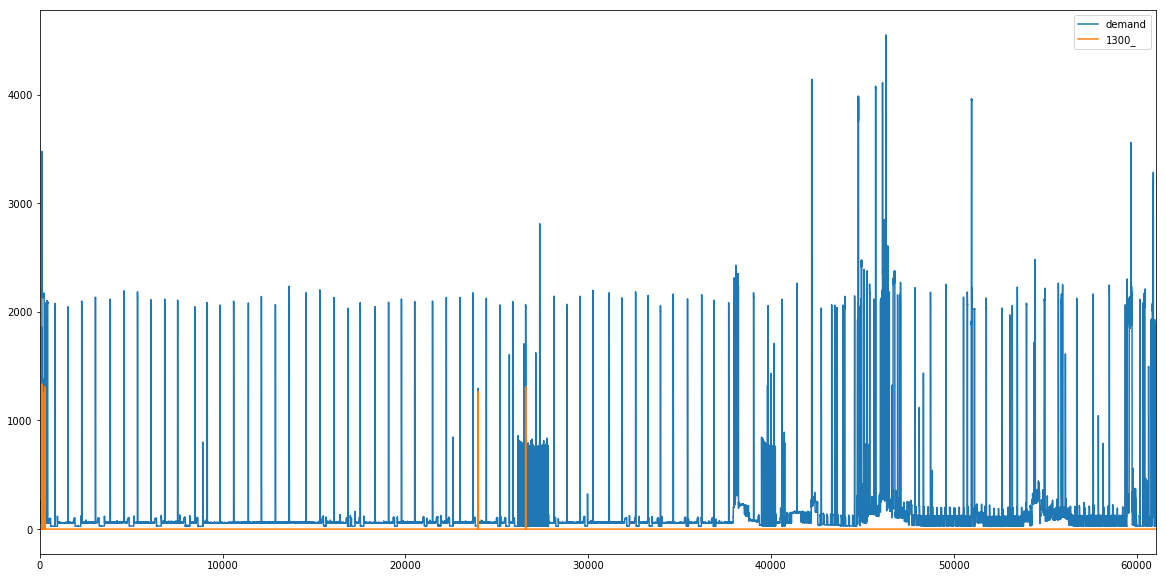

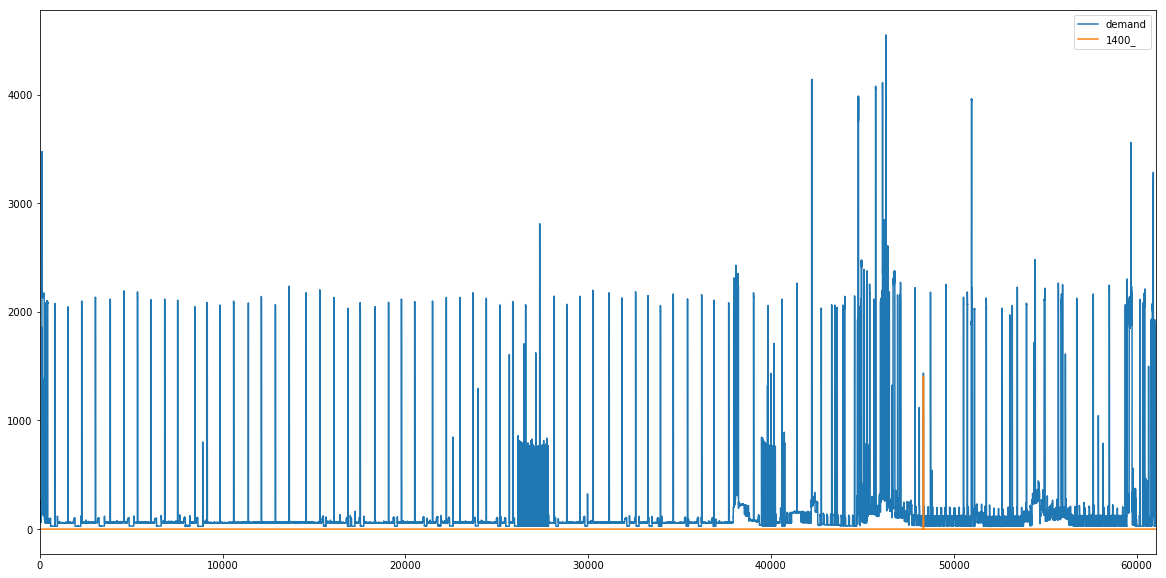

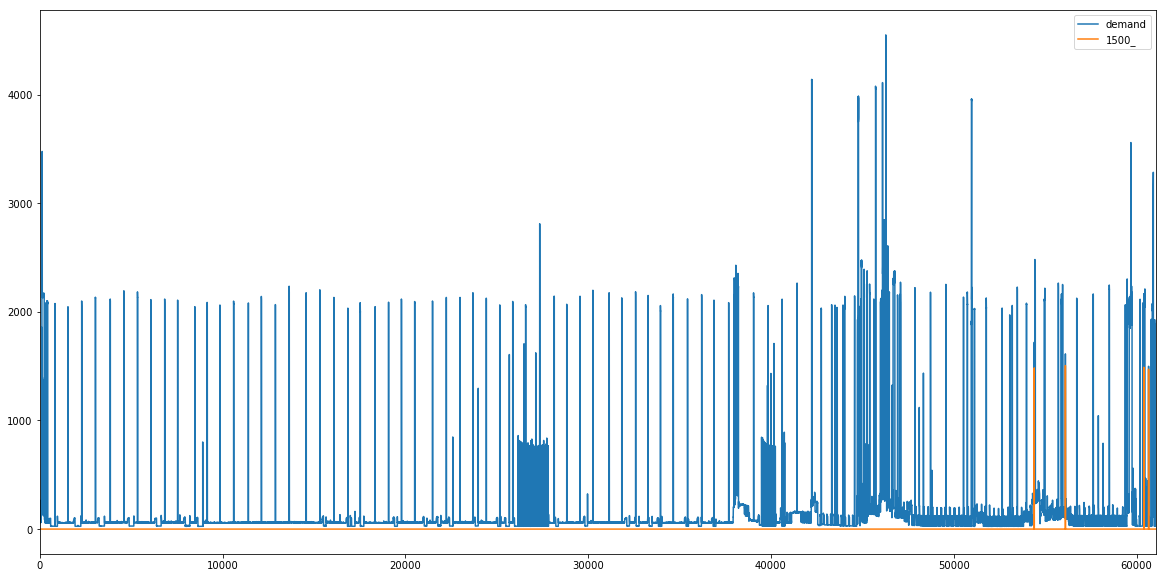

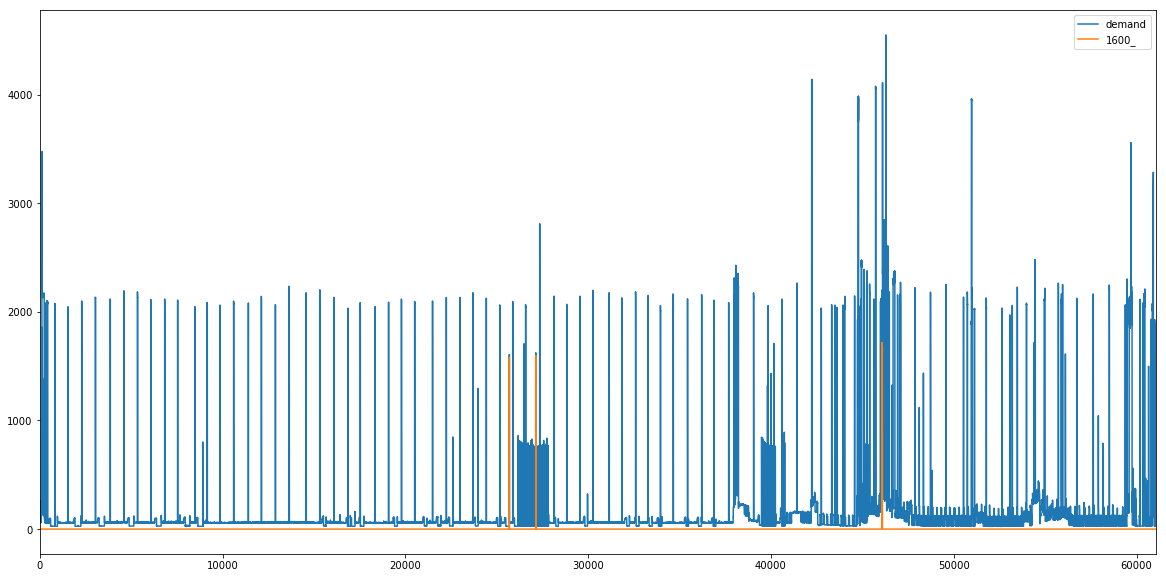

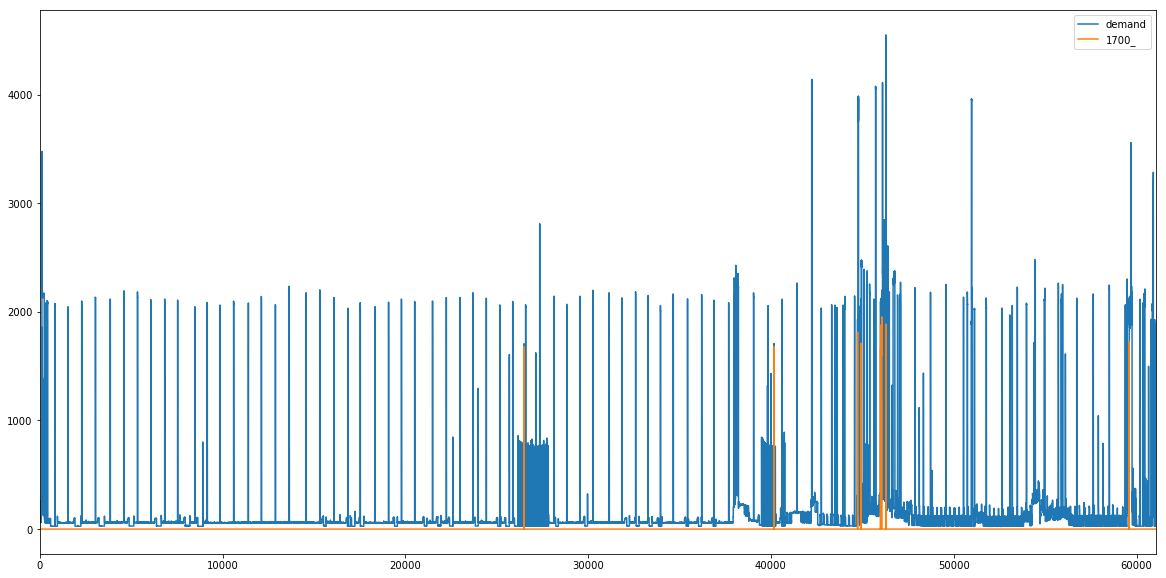

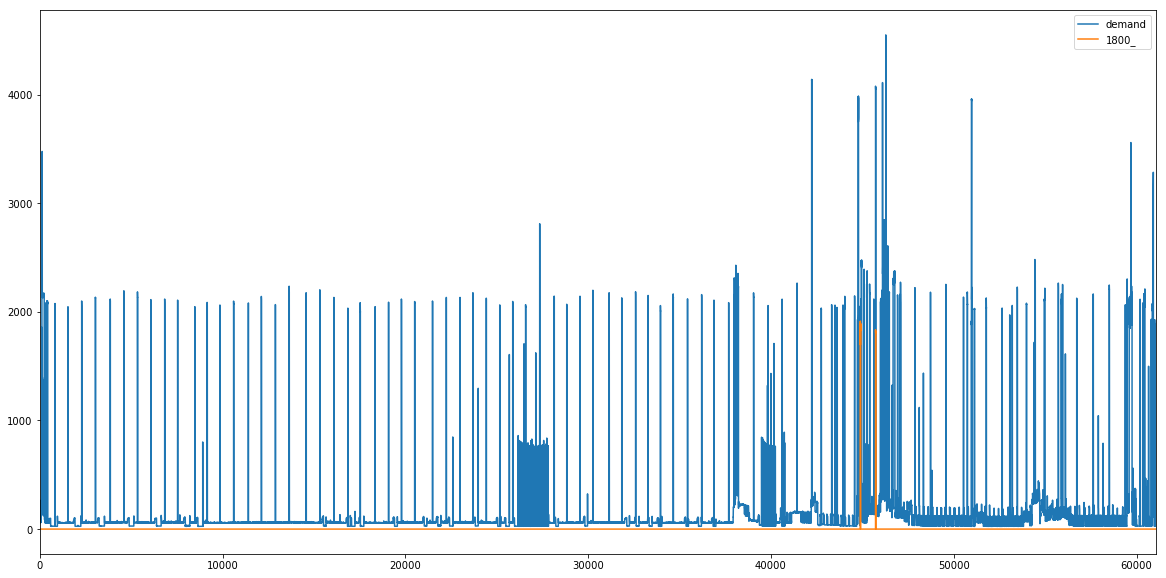

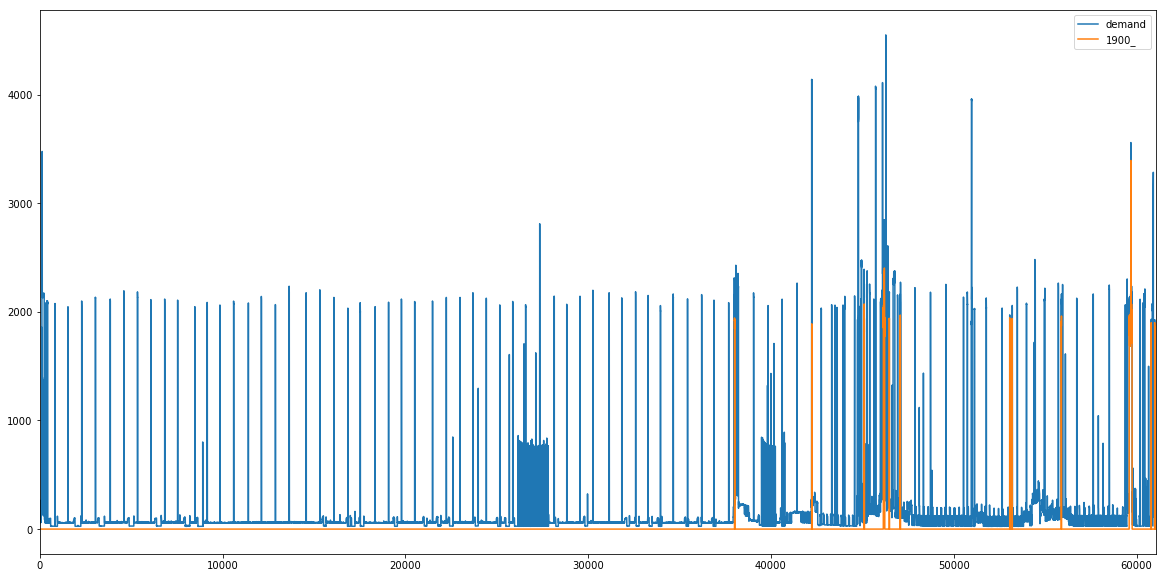

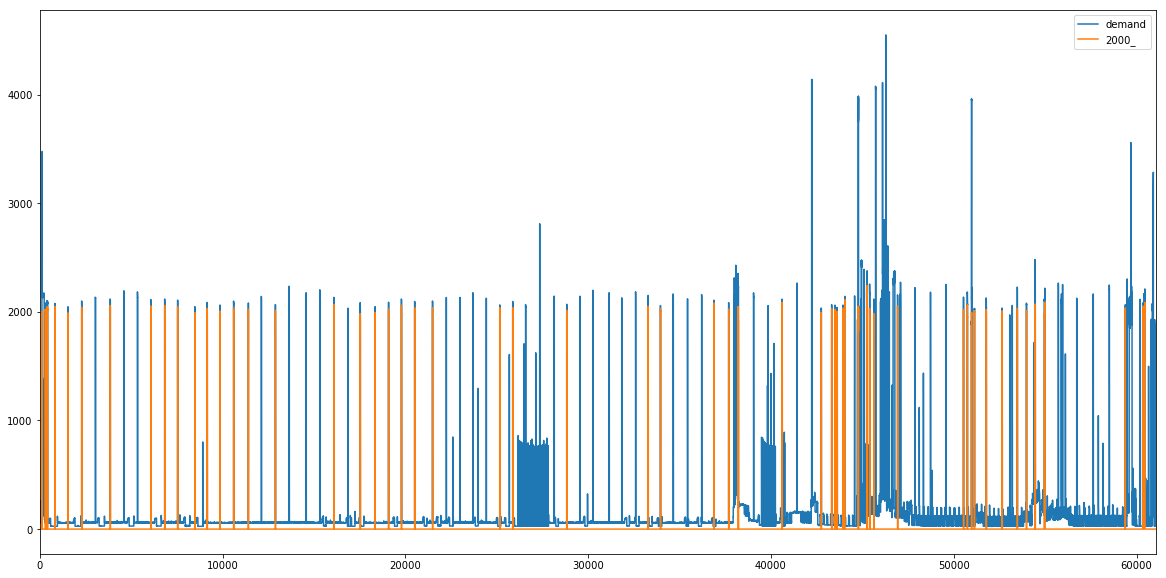

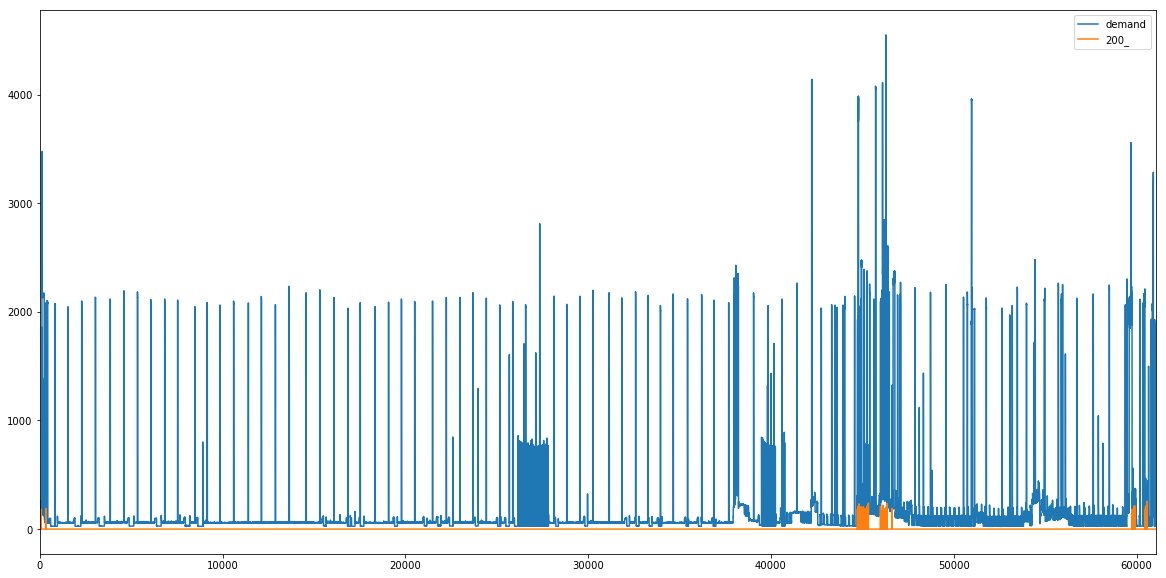

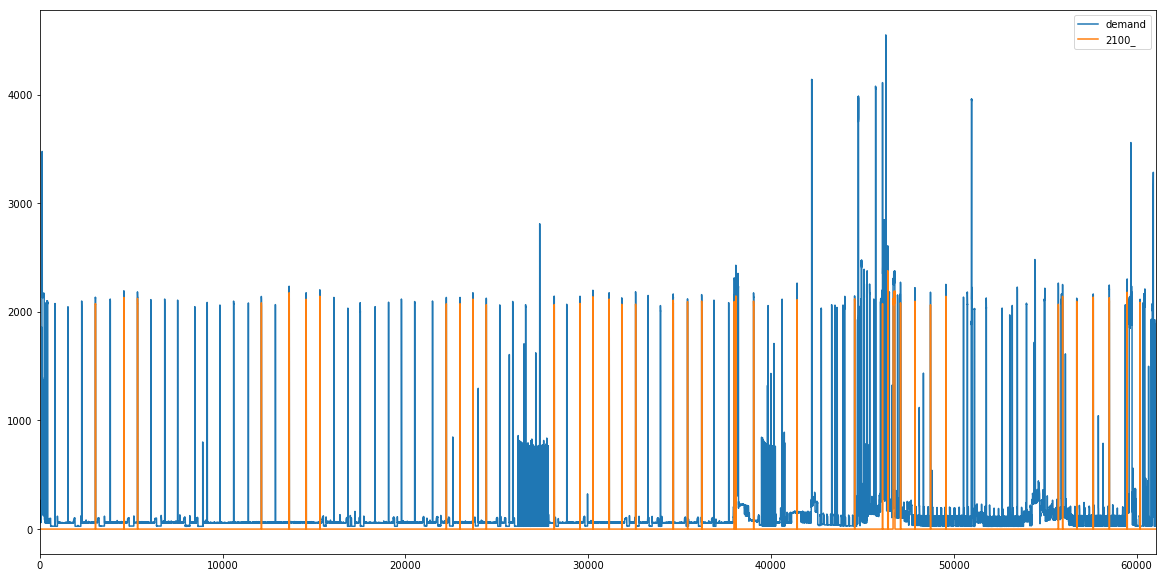

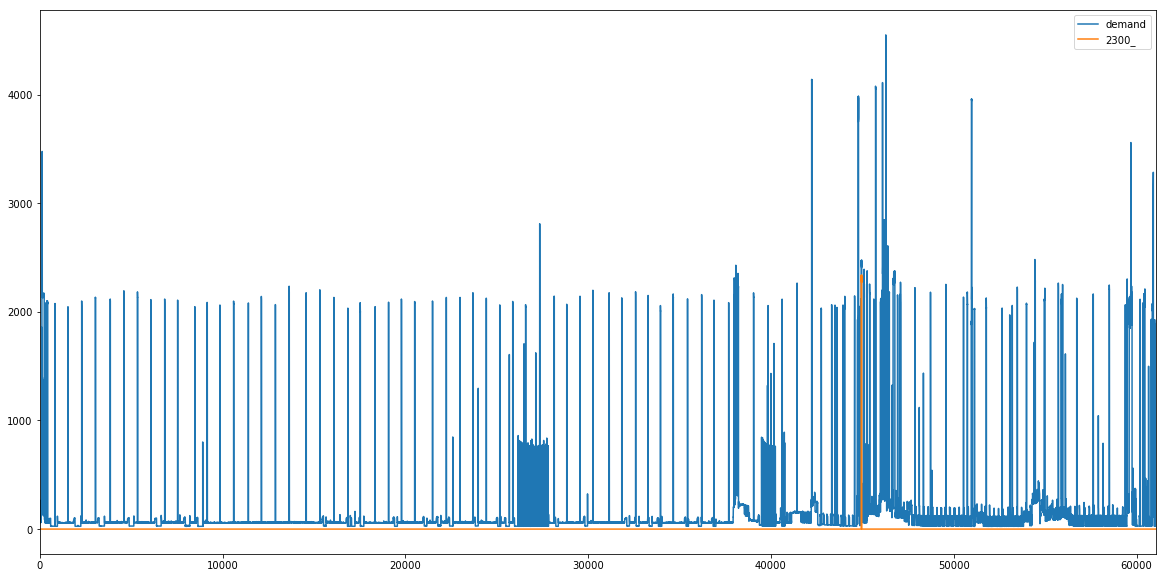

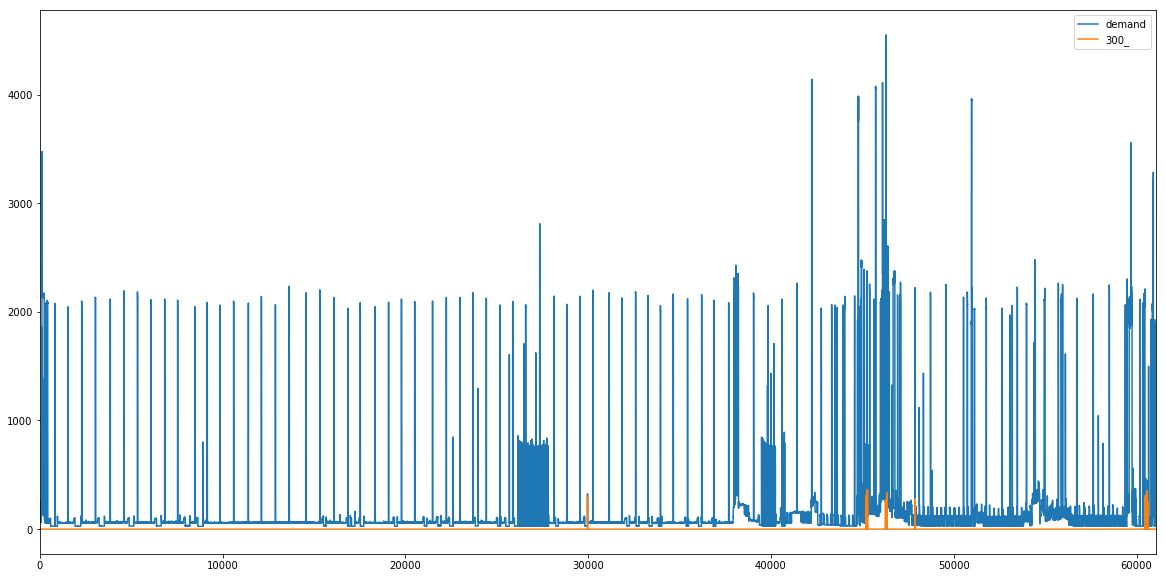

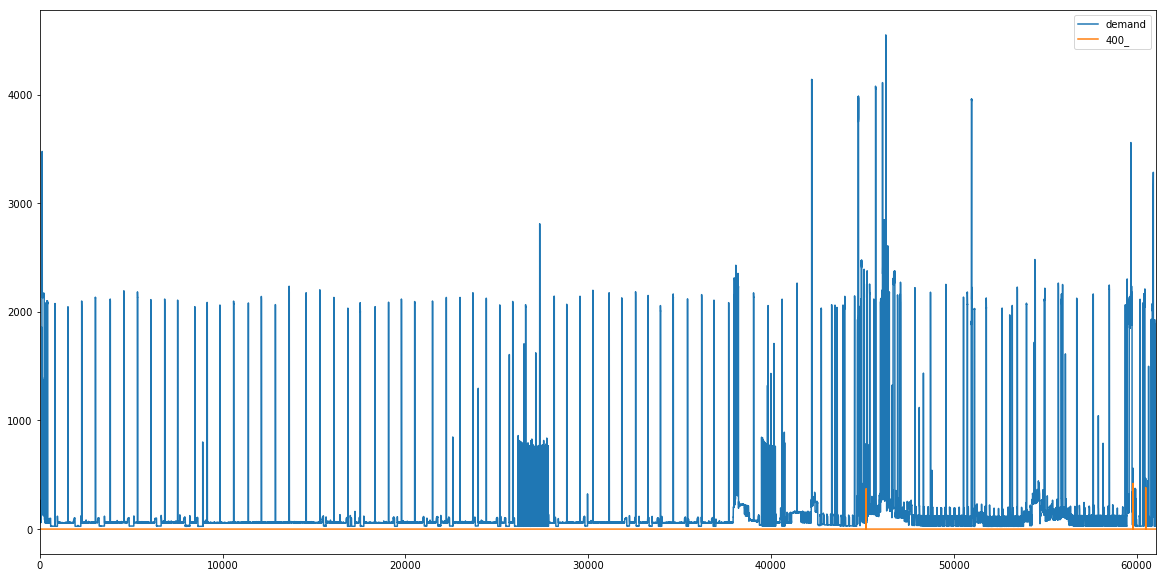

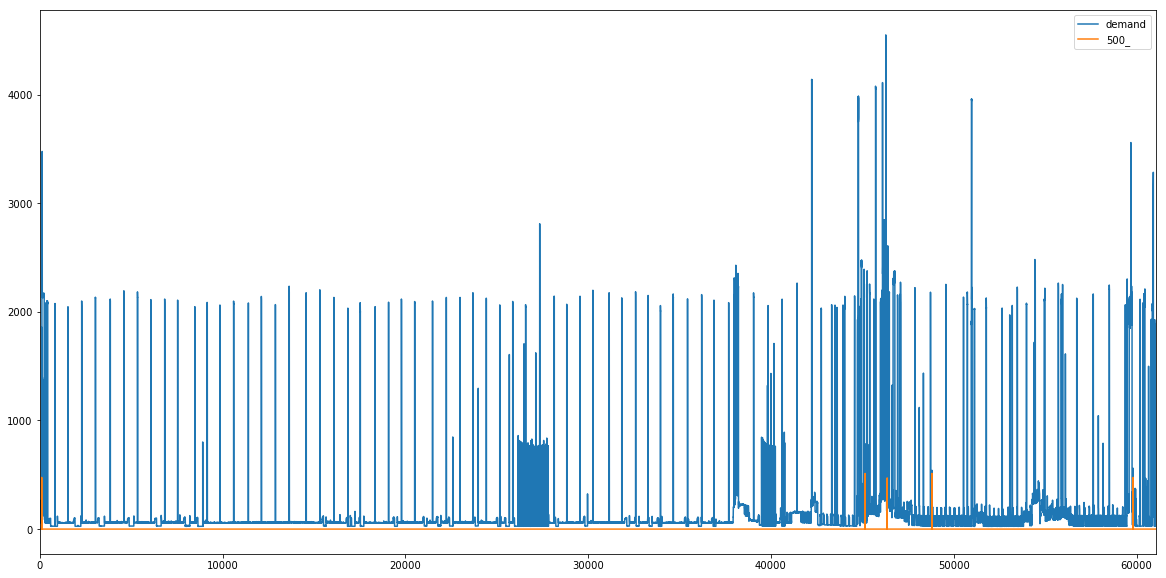

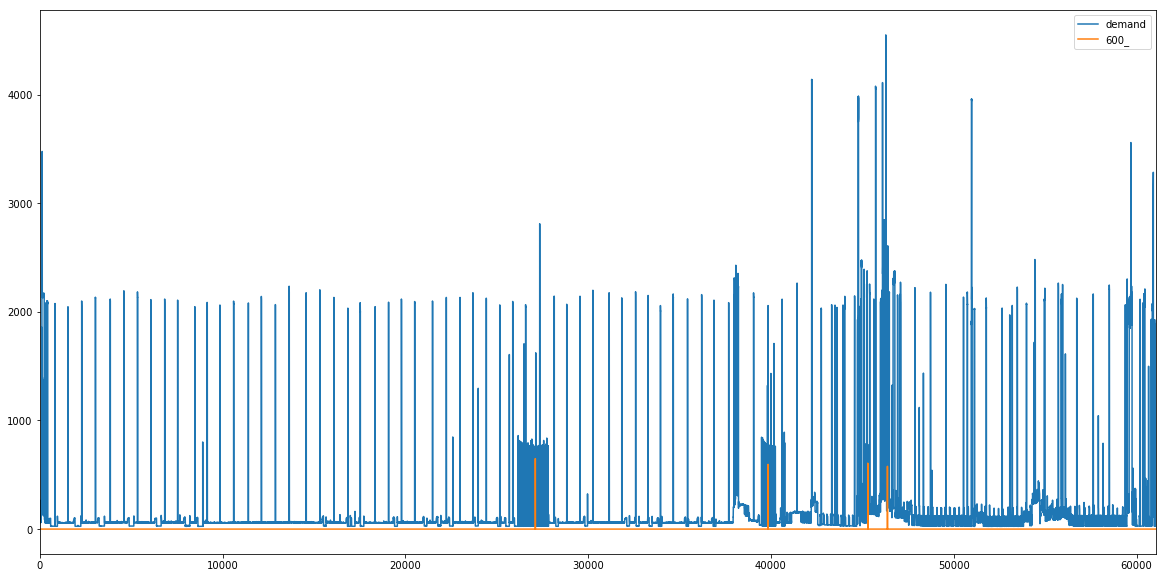

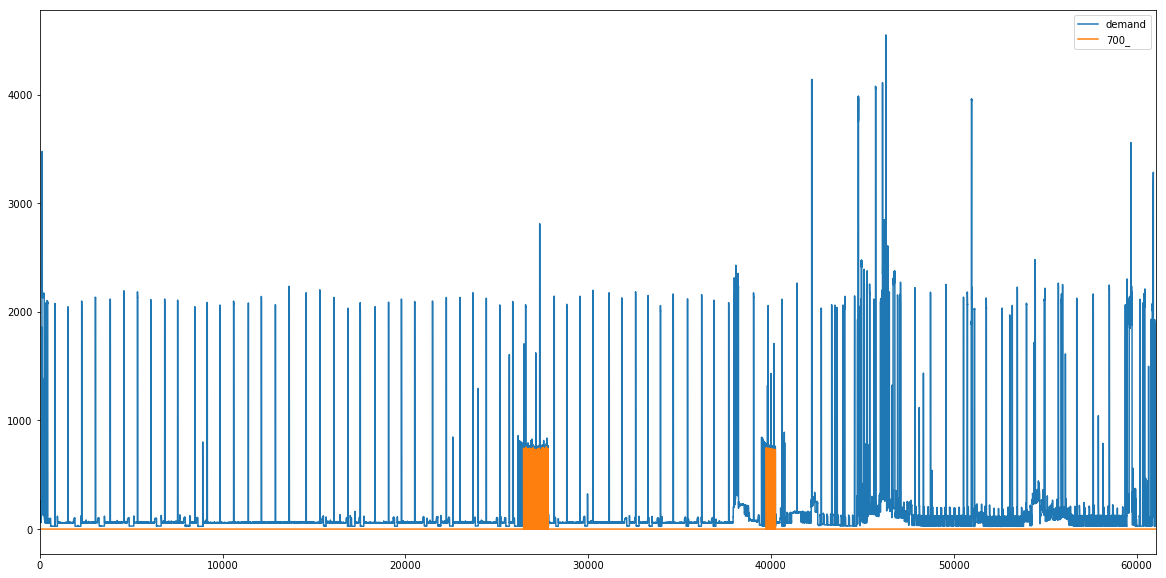

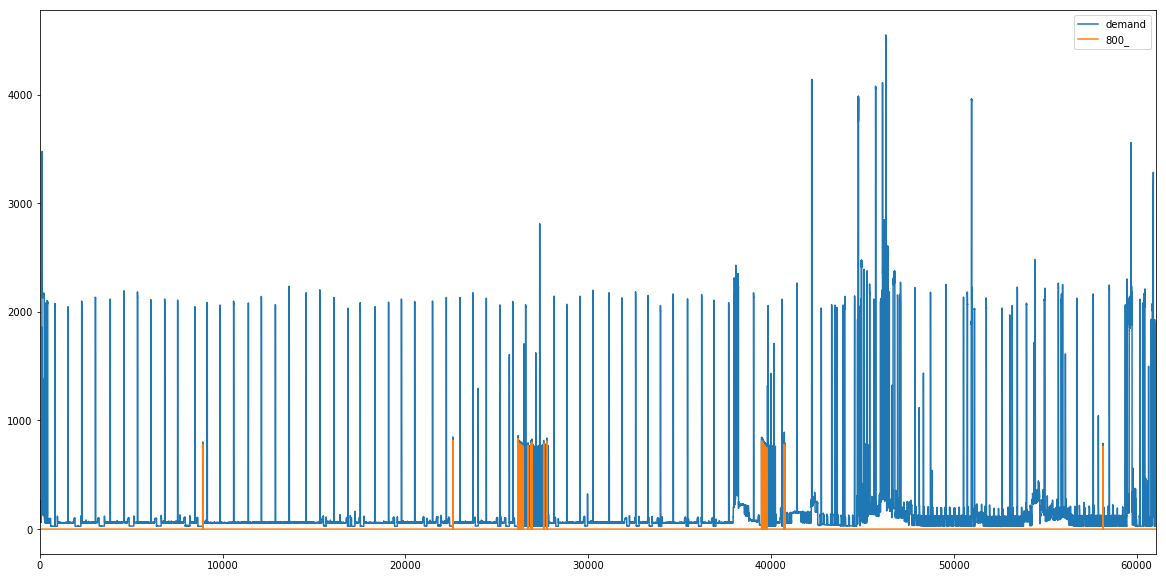

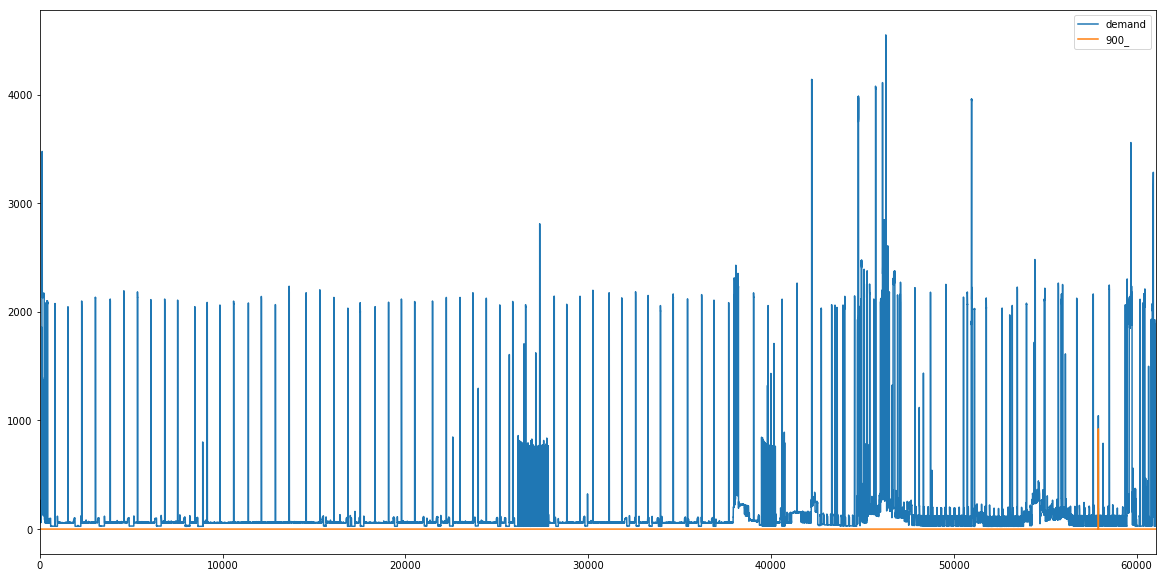

In [17]:
#print(df.loc[7770:7847,['demand','baseload','unknown','800_']])
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df.loc[:,['demand','dp','800_']].plot(figsize=(20,10))
for i in sorted(loads):
    print(i,'has',len(loads[i]),'occurance(s)')
    df.loc[:,['demand',i]].plot(figsize=(20,10))


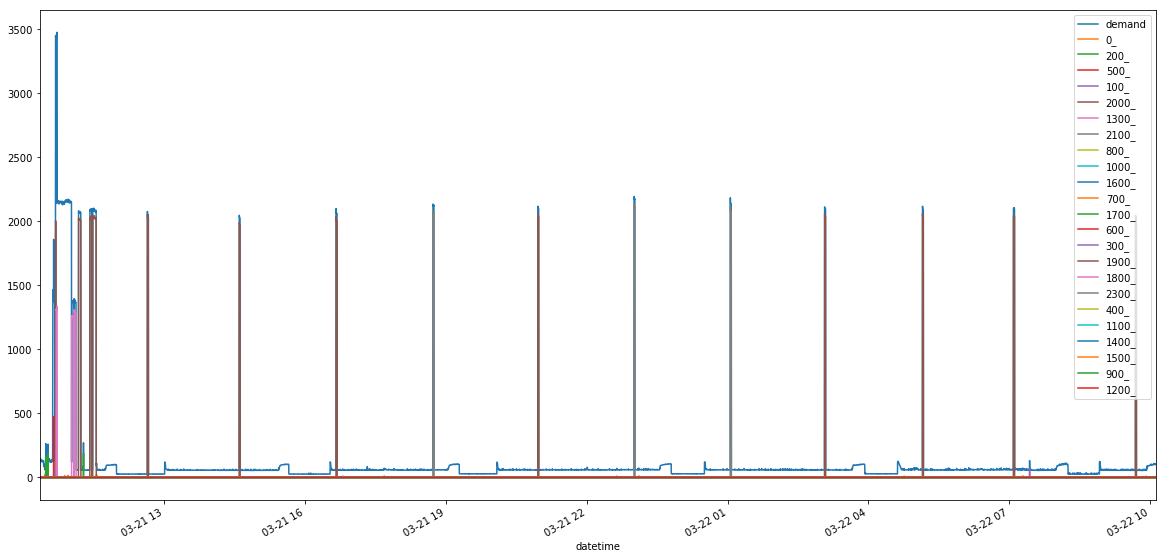

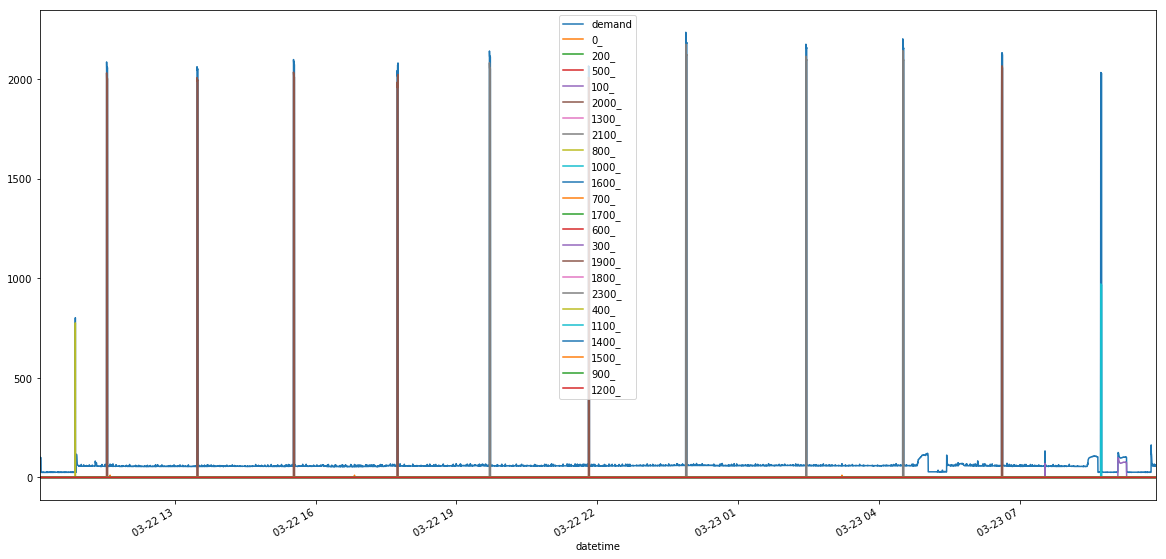

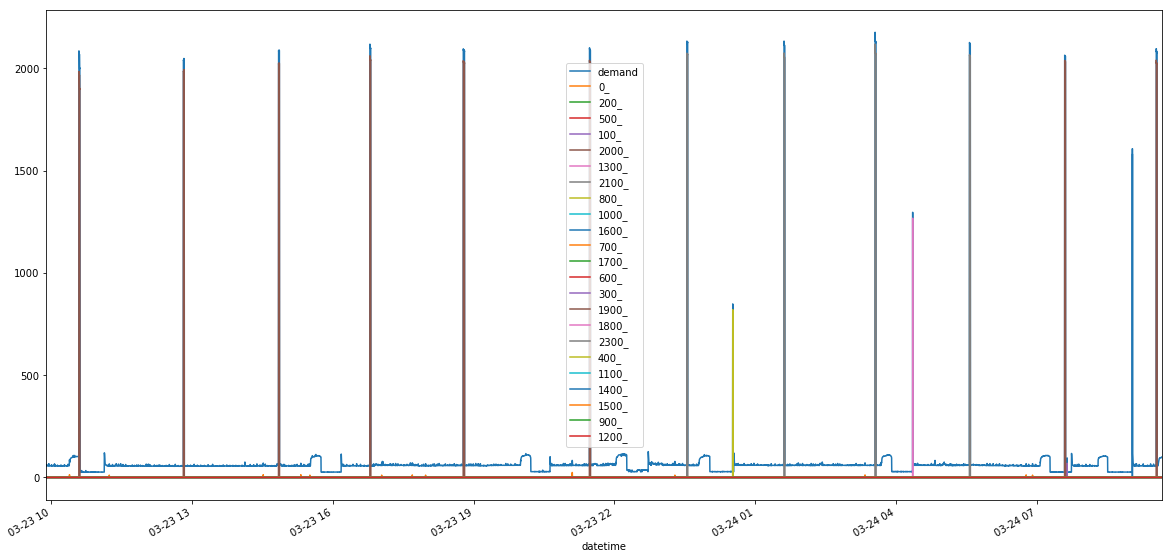

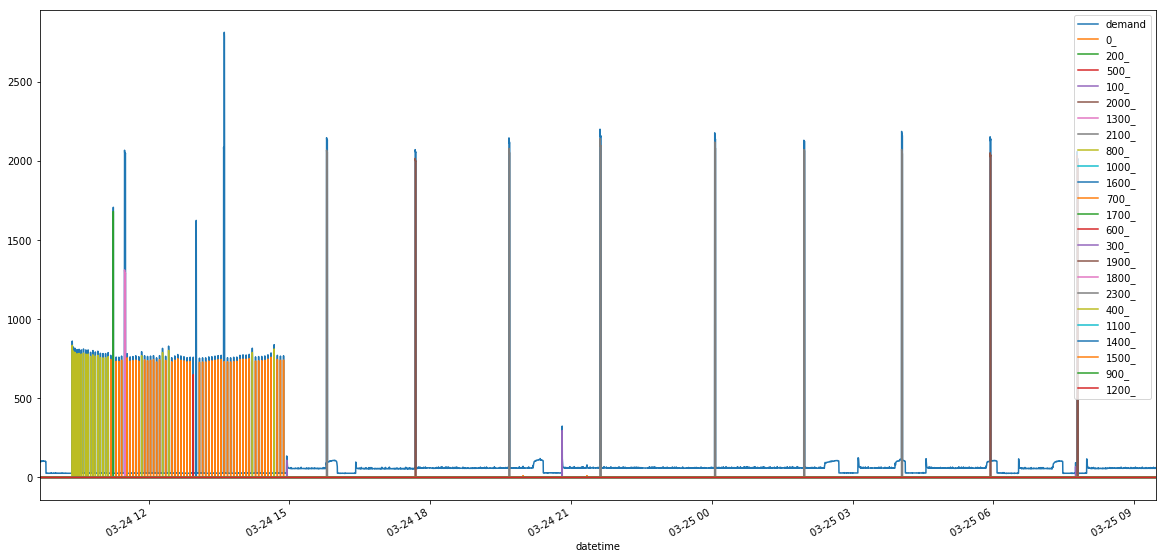

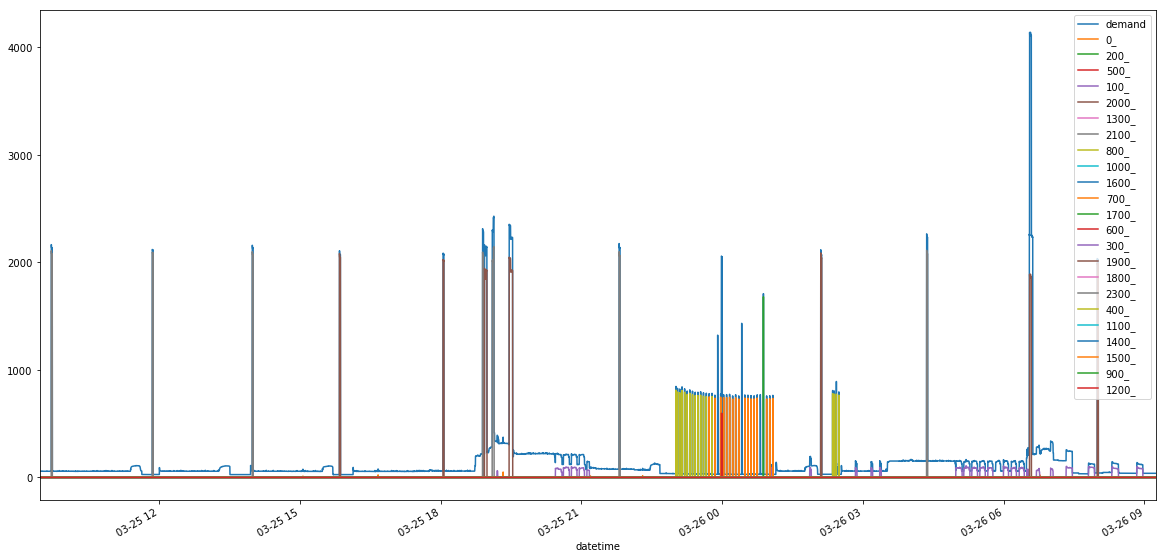

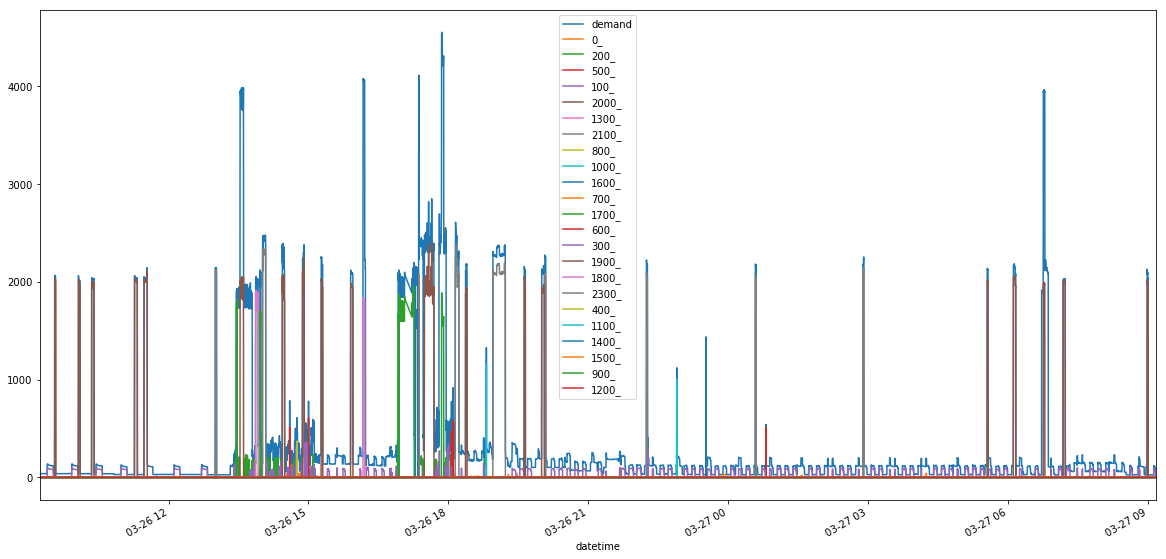

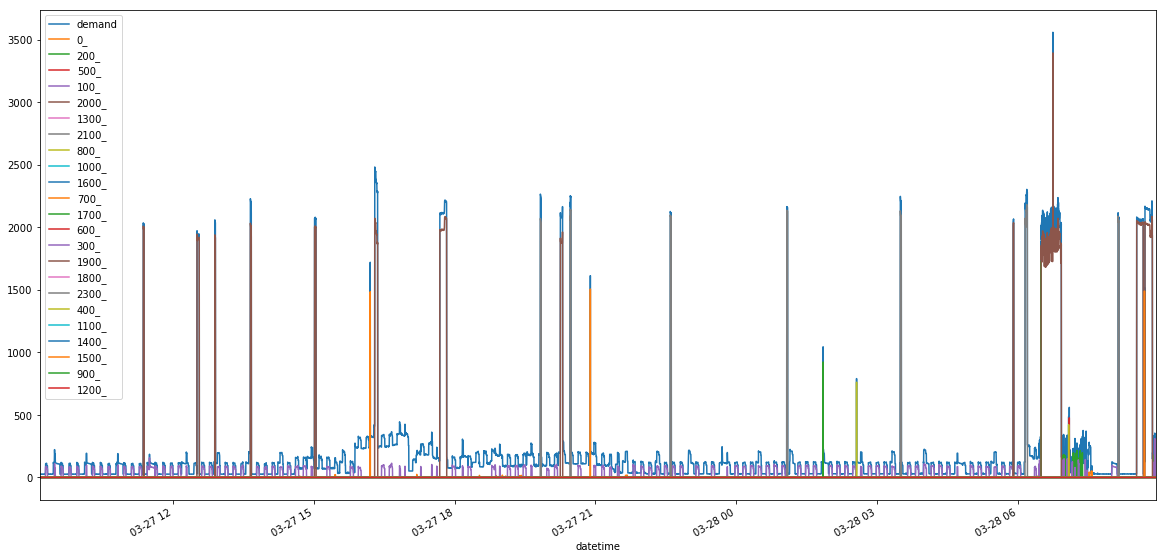

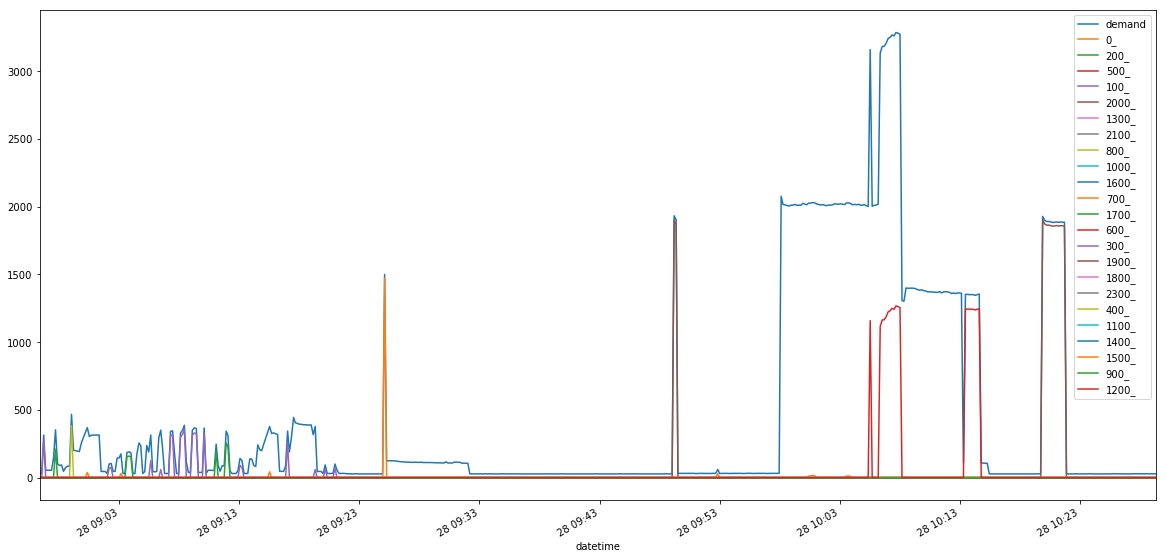

In [18]:
#print(df)
l = list(loads)
l.insert(0, 'datetime')
l.insert(1, 'demand')


step = 360*24 
for i in range(1,len(df),step):
    df.loc[i:i+step,l].plot(x=df.loc[i:i+step,'datetime'],figsize=(20,10))
                            #,kind='area')#,stacked=true)    


                 datetime  demand  0_  200_  500_  100_  2000_  1300_  2100_  \
60481 2018-03-28 08:56:22    31.0   0     0     0     0      0      0      0   
60482 2018-03-28 08:56:32    31.0   0     0     0     0      0      0      0   
60483 2018-03-28 08:56:42   314.0   0     0     0     0      0      0      0   
60484 2018-03-28 08:56:52    54.0   0     0     0     0      0      0      0   
60485 2018-03-28 08:57:02    54.0   0     0     0     0      0      0      0   
60486 2018-03-28 08:57:12    54.0   0     0     0     0      0      0      0   
60487 2018-03-28 08:57:21    54.0   0     0     0     0      0      0      0   
60488 2018-03-28 08:57:31   142.0   0     0     0     0      0      0      0   
60489 2018-03-28 08:57:41   352.0   0   210     0     0      0      0      0   
60490 2018-03-28 08:57:51   102.0   0     0     0     0      0      0      0   
60491 2018-03-28 08:58:01    89.0   0     0     0     0      0      0      0   
60492 2018-03-28 08:58:11    93.0   0   

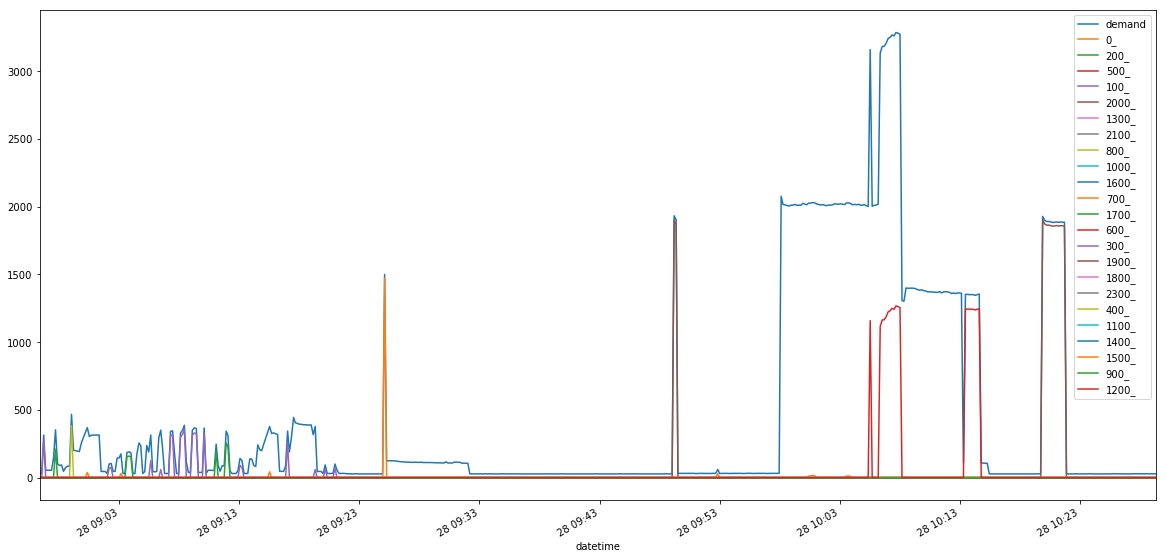

In [22]:
fig = df.loc[i:i+step,l].plot(x=df.loc[i:i+step,'datetime'],figsize=(20,10))
plt.savefig('test.png')

print(df.loc[i:i+step,l])

In [ ]:
# print(list(loads['100_'][0]))
for i in sorted(loads):
    print(i,'has',len(loads[i]),'occurance(s)')
    for load in loads[i]:
        if i == '100_':
            print(round(sum(loads[i][load]['profile'])/360,1),'Wh in ',loads[i][load]['time'])
            


In [ ]:
# print(loads)
for i in sorted(loads):
    plt.hold(True)
    for load in loads[i]:
        plt.plot(loads[i][load]['profile'][0:])
    plt.hold(False)
    plt.grid()
    plt.title(i,size=16)
    plt.show()
    


In [ ]:

# df[['datetime',list(loads)]].iplot()
temp = list(loads)
temp[0] = 'datetime'
temp[1] = 'baseload'
temp[2] = 'unknown'

temp[3:] =list(loads)
dp = df[temp]
dp = dp.set_index('datetime')
# dp.resample('10T').mean().iplot(kind='area',fill='tozeroy',mode='none')



In [ ]:
pie = dp.sum()
# values = pie.values/pie.sum()*100
# print(pie)
# print(pie/pie.sum())
round(pie/pie.sum()*100,1)
pie.plot(kind='pie',figsize=(10,10))

# write pie data to db

# Try to rename colums for 'kwown loads' 

In [ ]:
#relable output for known_loads
known_loads = {'100_':'Fridge','2000_':'Boiler'}
for name in loads.keys():
    try:
        df=df.rename(columns = {name:known_loads[name]})
        loads[known_loads[name]] = loads[name]
    except:
        print(name,'not found known_loads')
    
for name in known_loads:
    try:
        del loads[name]
    except:
        print(name,'not found in legend')

legend = loads.keys()
print(list(legend))

In [ ]:
#function left_round round number left of the decimal point. (NEEDS A FIX)
def left_round(number,precision=2):
    rem = number

    d = len(str(number))
    while(round(rem,d) == round(number,d)):
        rem = round(number,d-precision)
        d = d -1
        
    i = 0
    while(rem > 10**precision):
        rem = round(rem / 10,0)
        i = i +1
#         print(rem*(10**i))
        if i > 100:
            break
    return rem*(10**i)

left_round(00.00034564,3)

left_round(122431234.00034564,3)

# left_round(123456)